In [1]:
cd ..

F:\Programming\Competitions\aaa Dacon - HAICon2021


In [2]:
from Models import get_ViT_tuner2
from Steps import search_and_train, get_threshold, test_and_save

class argparser:
    sequence_length = 100
    sequence_stride = 3
    batch_size = 128
    scaler_type = 'minmax'
    anomaly_smoothing = False
    model_name = 'transformer2'
args = argparser()

In [3]:
model, selected_cols, scaler = search_and_train(args, get_ViT_tuner2, timelen=args.sequence_length)

INFO:tensorflow:Reloading Oracle from existing project search_saved/transformer2\oracle.json
INFO:tensorflow:Reloading Tuner from search_saved/transformer2\tuner0.json
INFO:tensorflow:Oracle triggered exit
Results summary
Results in search_saved/transformer2
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
n_encoders: 8
n_heads: 8
att_dropout: 0.2
fwd_num: 4
fwd_dropout: 0.2
optimizer: Adam
lr: 0.0001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.004818640183657408
loading latest ckpt: saved_models//transformer2\final


In [4]:
from DatasetModules import load_dataset, HAIDataLoader
from settings import VALIDATION_FOLDER

np_validation_list, attack = load_dataset(VALIDATION_FOLDER,
                                          selected_cols=selected_cols,
                                          scaler=scaler,
                                          ewm=False,
                                          validation=True)
validation_dataset = HAIDataLoader(np_validation_list,
                                   length=args.sequence_length,
                                   stride=1,
                                   batch_size=args.batch_size,
                                   train=False)

In [5]:
from Steps.Helpers import test_and_get_list, find_th
validation_result = test_and_get_list(model, validation_dataset, np_validation_list, args)

In [6]:
import pandas as pd
from scipy.signal import lfilter, savgol_filter
import statsmodels.api as sm


def filter0_factory(window_size):
    def filter0(val_res):
        anomaly_score_series = pd.Series(val_res)
        return anomaly_score_series.rolling(window=window_size, min_periods=1).mean().values
    return filter0

def filter1_factory(n):  # Filter data along one-dimension with an IIR or FIR filter.
    def filter1(val_res):
        b = [1.0 / n] * n
        a = 1
        return lfilter(b,a,val_res)
    return filter1

def filter2_factory(window_size):  # Apply a Savitzky-Golay filter to an array.
    def filter2(val_res):
        return savgol_filter(val_res, window_size, 2)
    return filter2

def filter3_factory(fractional):  # LOWESS
    def filter3(val_res):
        x = list(range(len(val_res)))
        y_lowess = sm.nonparametric.lowess(y, x, frac = fractional)
        return y_lowess[:, 1]
    return filter3

In [7]:
import numpy as np
np.unique(attack)

array([0, 1], dtype=int64)

In [8]:
tt = np.array([0 if x < 0.01 else 0.01 for x in attack])
np.unique(tt)

array([0.  , 0.01])

In [9]:
import matplotlib.pyplot as plt
def noise_filtering_test(parameters, filters):
    res = []
    for p, f in zip(parameters, filters):
        print(f"parameter : {p}")
        var_res = f(validation_result)
        plt.figure(figsize=(100,50))
        plt.plot(var_res)
        plt.plot(tt)
        _, temp = find_th(args, attack, var_res)
        res.append(temp + [p])
    for li in sorted(res):
        F1, TaP, TaR, parameter = li
        print(f"F1: {F1}, TaP: {TaP}, TaR: {TaR}, parameter: {parameter}")

Finding Threshold:   0%|                                                              | 1/2000 [00:00<04:37,  7.21it/s]

parameter : 5


Finding Threshold: 100%|███████████████████████████████████████████████████████████| 2000/2000 [04:01<00:00,  8.30it/s]


F1: 0.238 (TaP: 0.276, TaR: 0.209)
# of detected anomalies: 3
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x00000261B8CBDE50>, <TaPR_pkg.DataManage.Range.Range object at 0x00000261B8CBDBB0>, <TaPR_pkg.DataManage.Range.Range object at 0x00000261B8CBD910>]
Threshold :  0.005325399999999999


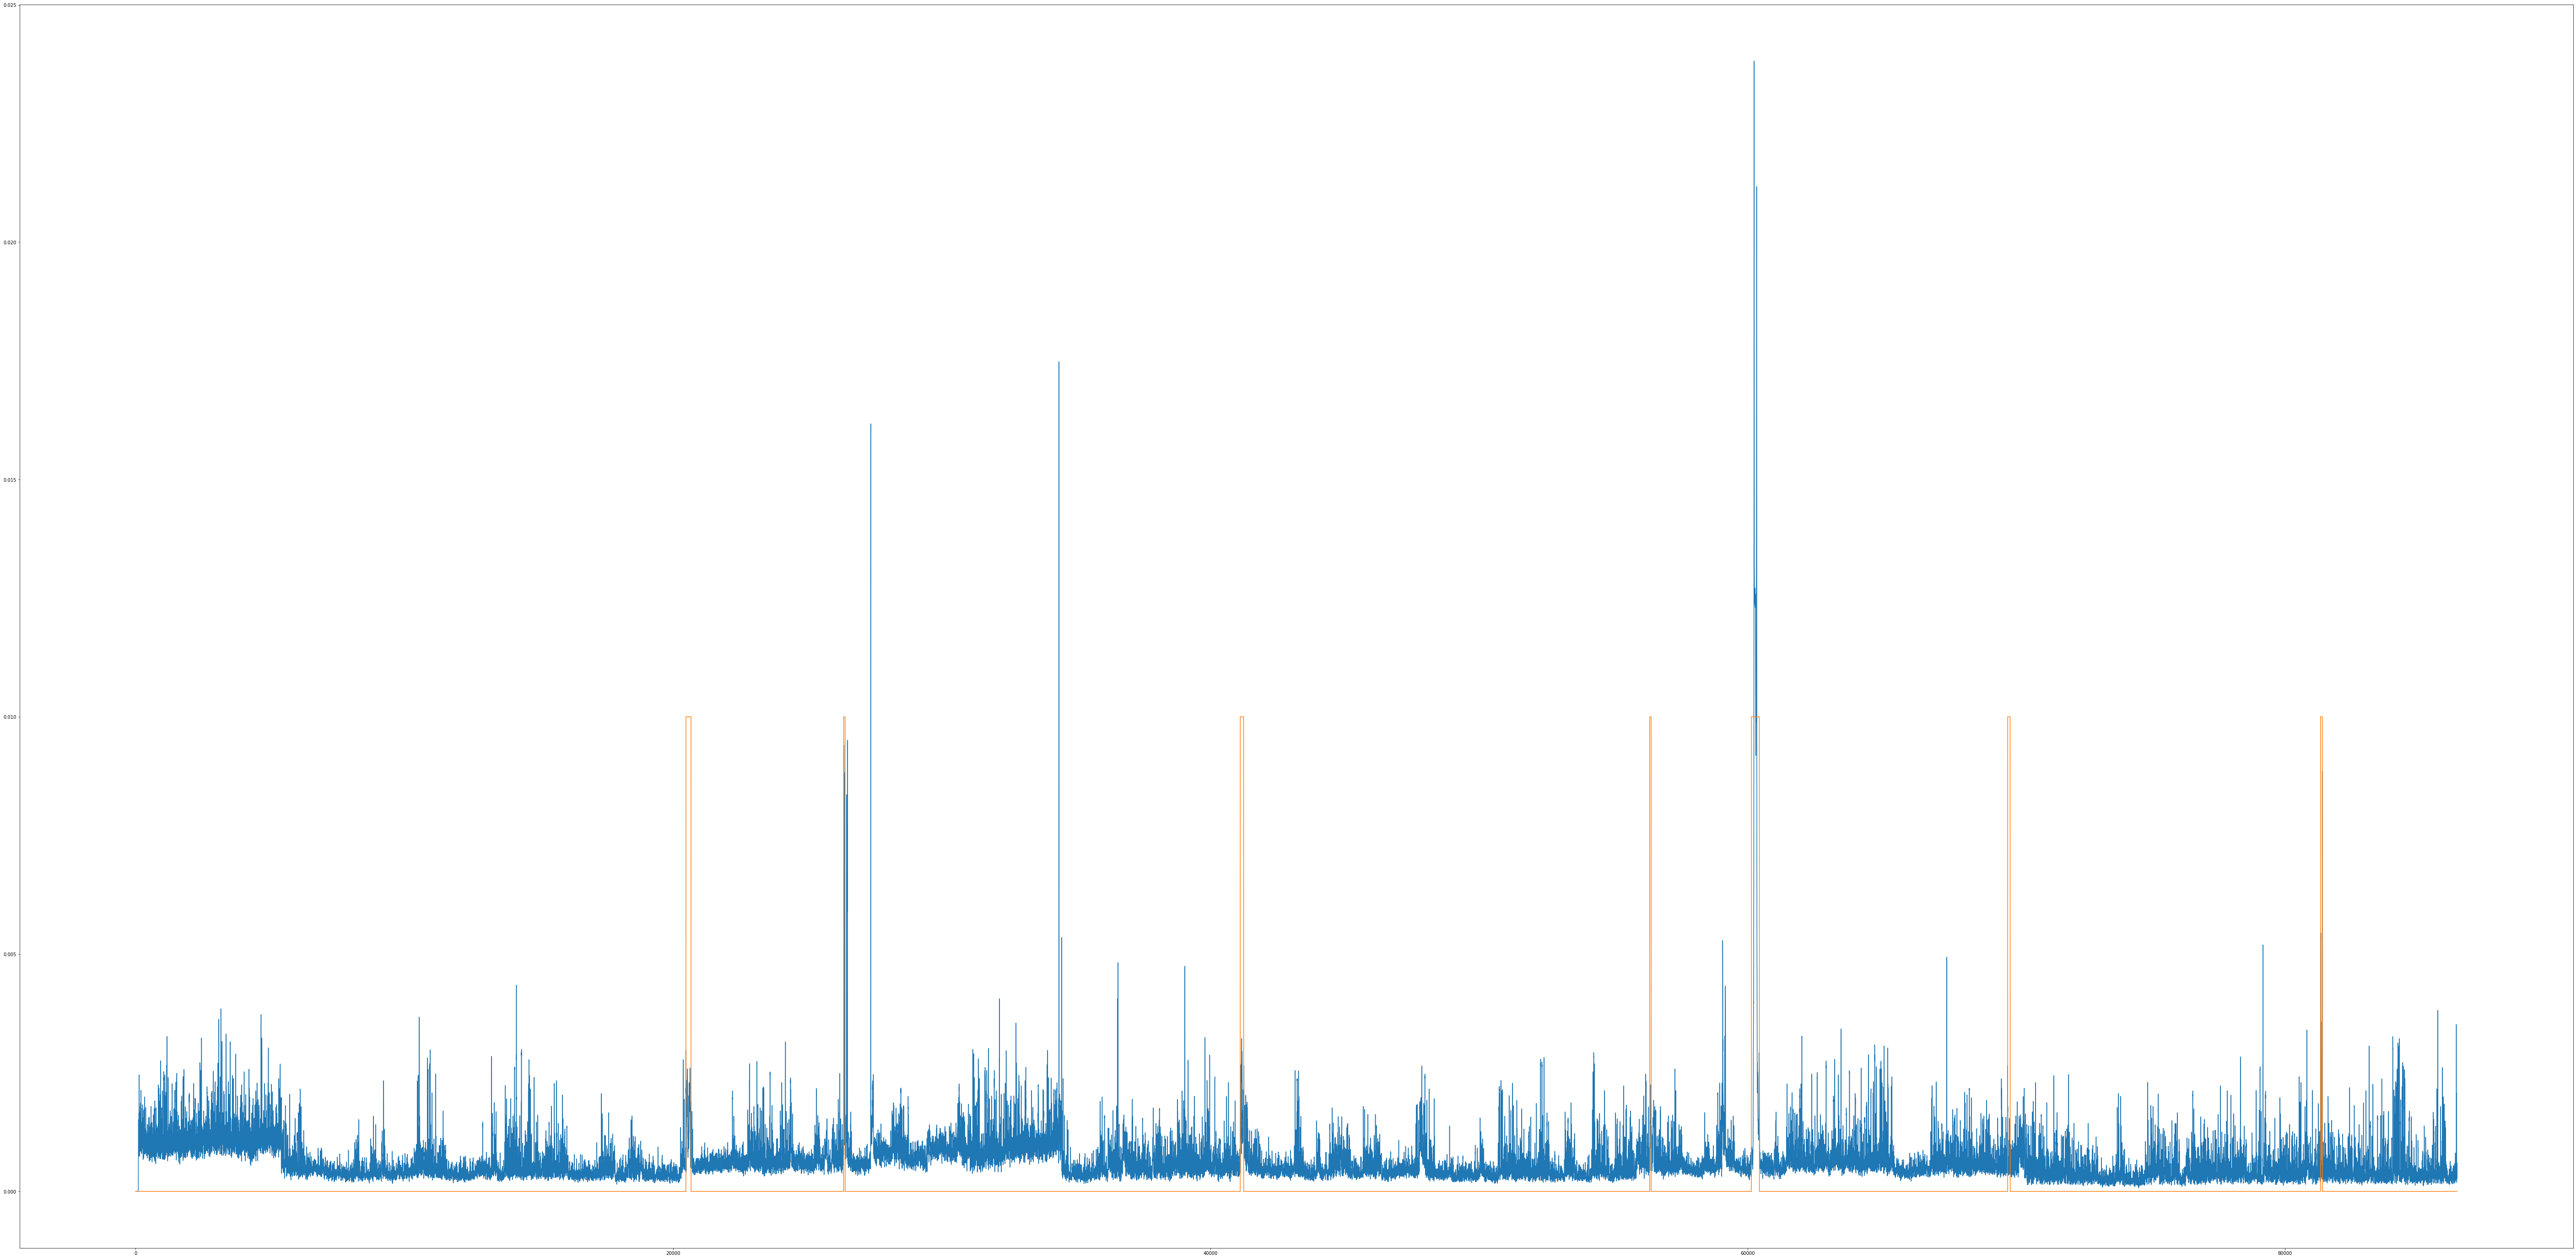

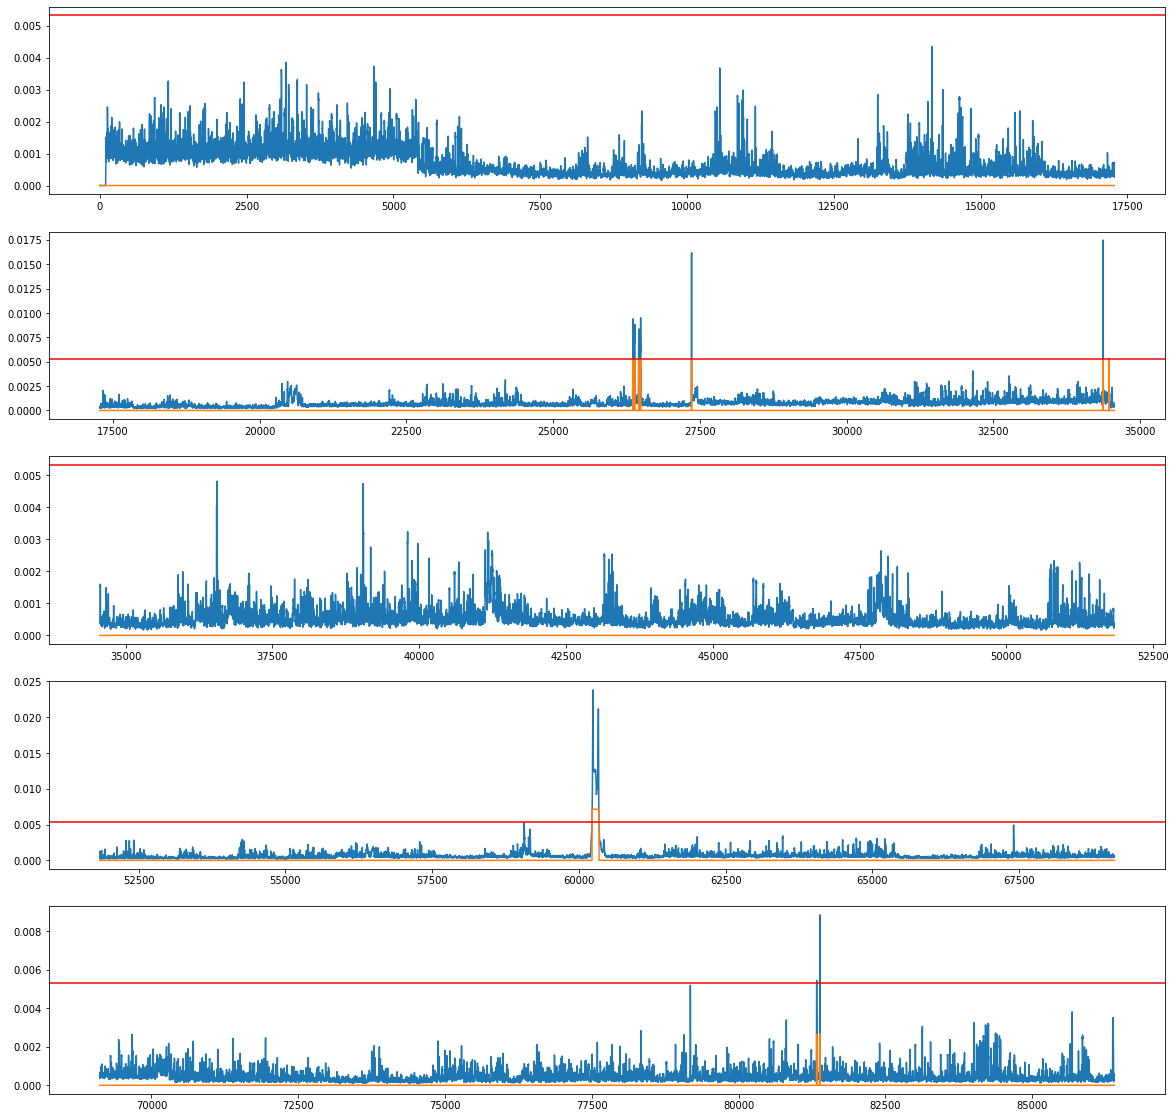

Finding Threshold:   0%|                                                              | 1/2000 [00:00<03:55,  8.50it/s]

parameter : 10


Finding Threshold: 100%|███████████████████████████████████████████████████████████| 2000/2000 [03:40<00:00,  9.05it/s]


F1: 0.247 (TaP: 0.263, TaR: 0.233)
# of detected anomalies: 3
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x00000261B6D9A790>, <TaPR_pkg.DataManage.Range.Range object at 0x00000261B980F850>, <TaPR_pkg.DataManage.Range.Range object at 0x00000261B980F760>]
Threshold :  0.003777


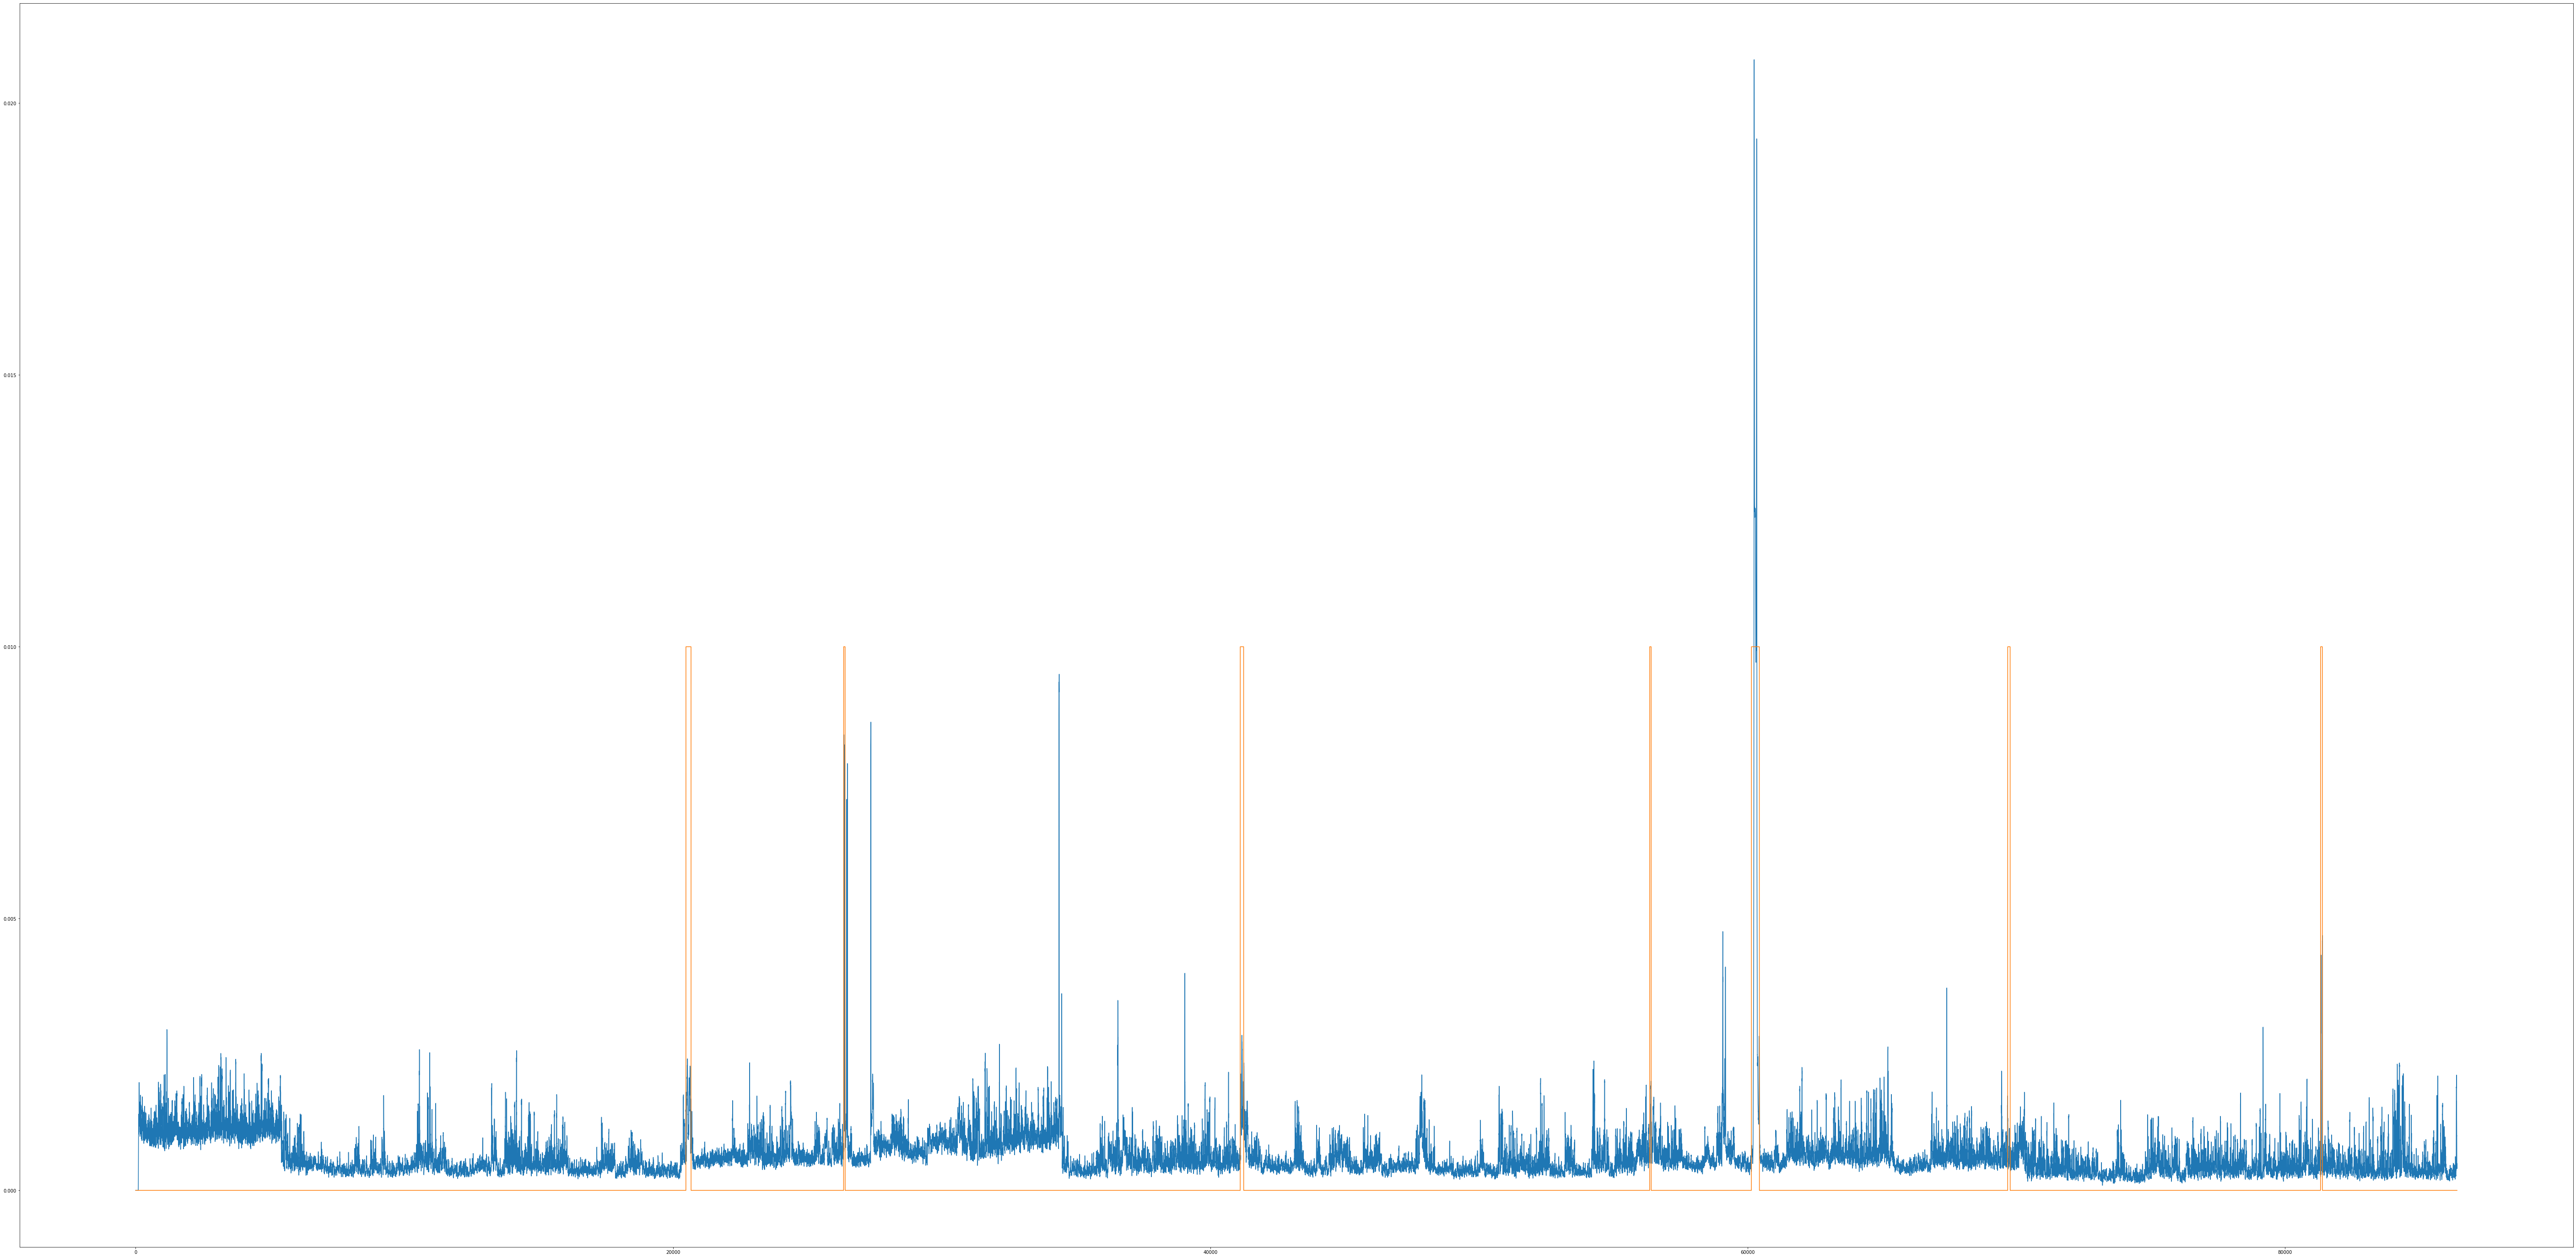

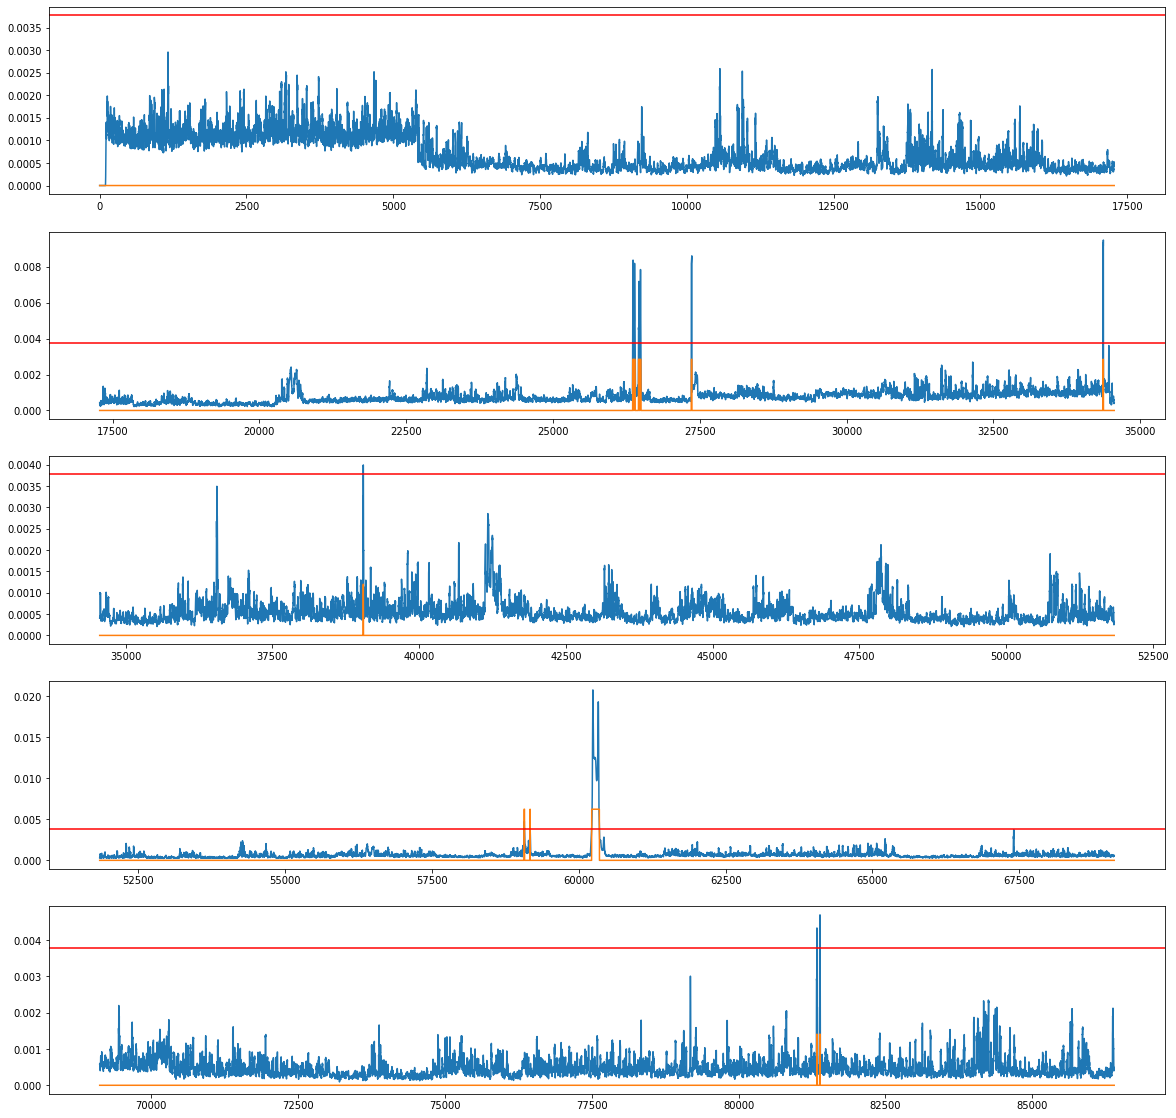

Finding Threshold:   0%|                                                              | 1/2000 [00:00<03:45,  8.87it/s]

parameter : 15


Finding Threshold: 100%|███████████████████████████████████████████████████████████| 2000/2000 [03:34<00:00,  9.34it/s]


F1: 0.260 (TaP: 0.214, TaR: 0.332)
# of detected anomalies: 4
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x00000261005CD670>, <TaPR_pkg.DataManage.Range.Range object at 0x00000261B6ECAC40>, <TaPR_pkg.DataManage.Range.Range object at 0x00000261B7991F40>, <TaPR_pkg.DataManage.Range.Range object at 0x00000261B97BEAF0>]
Threshold :  0.0023805


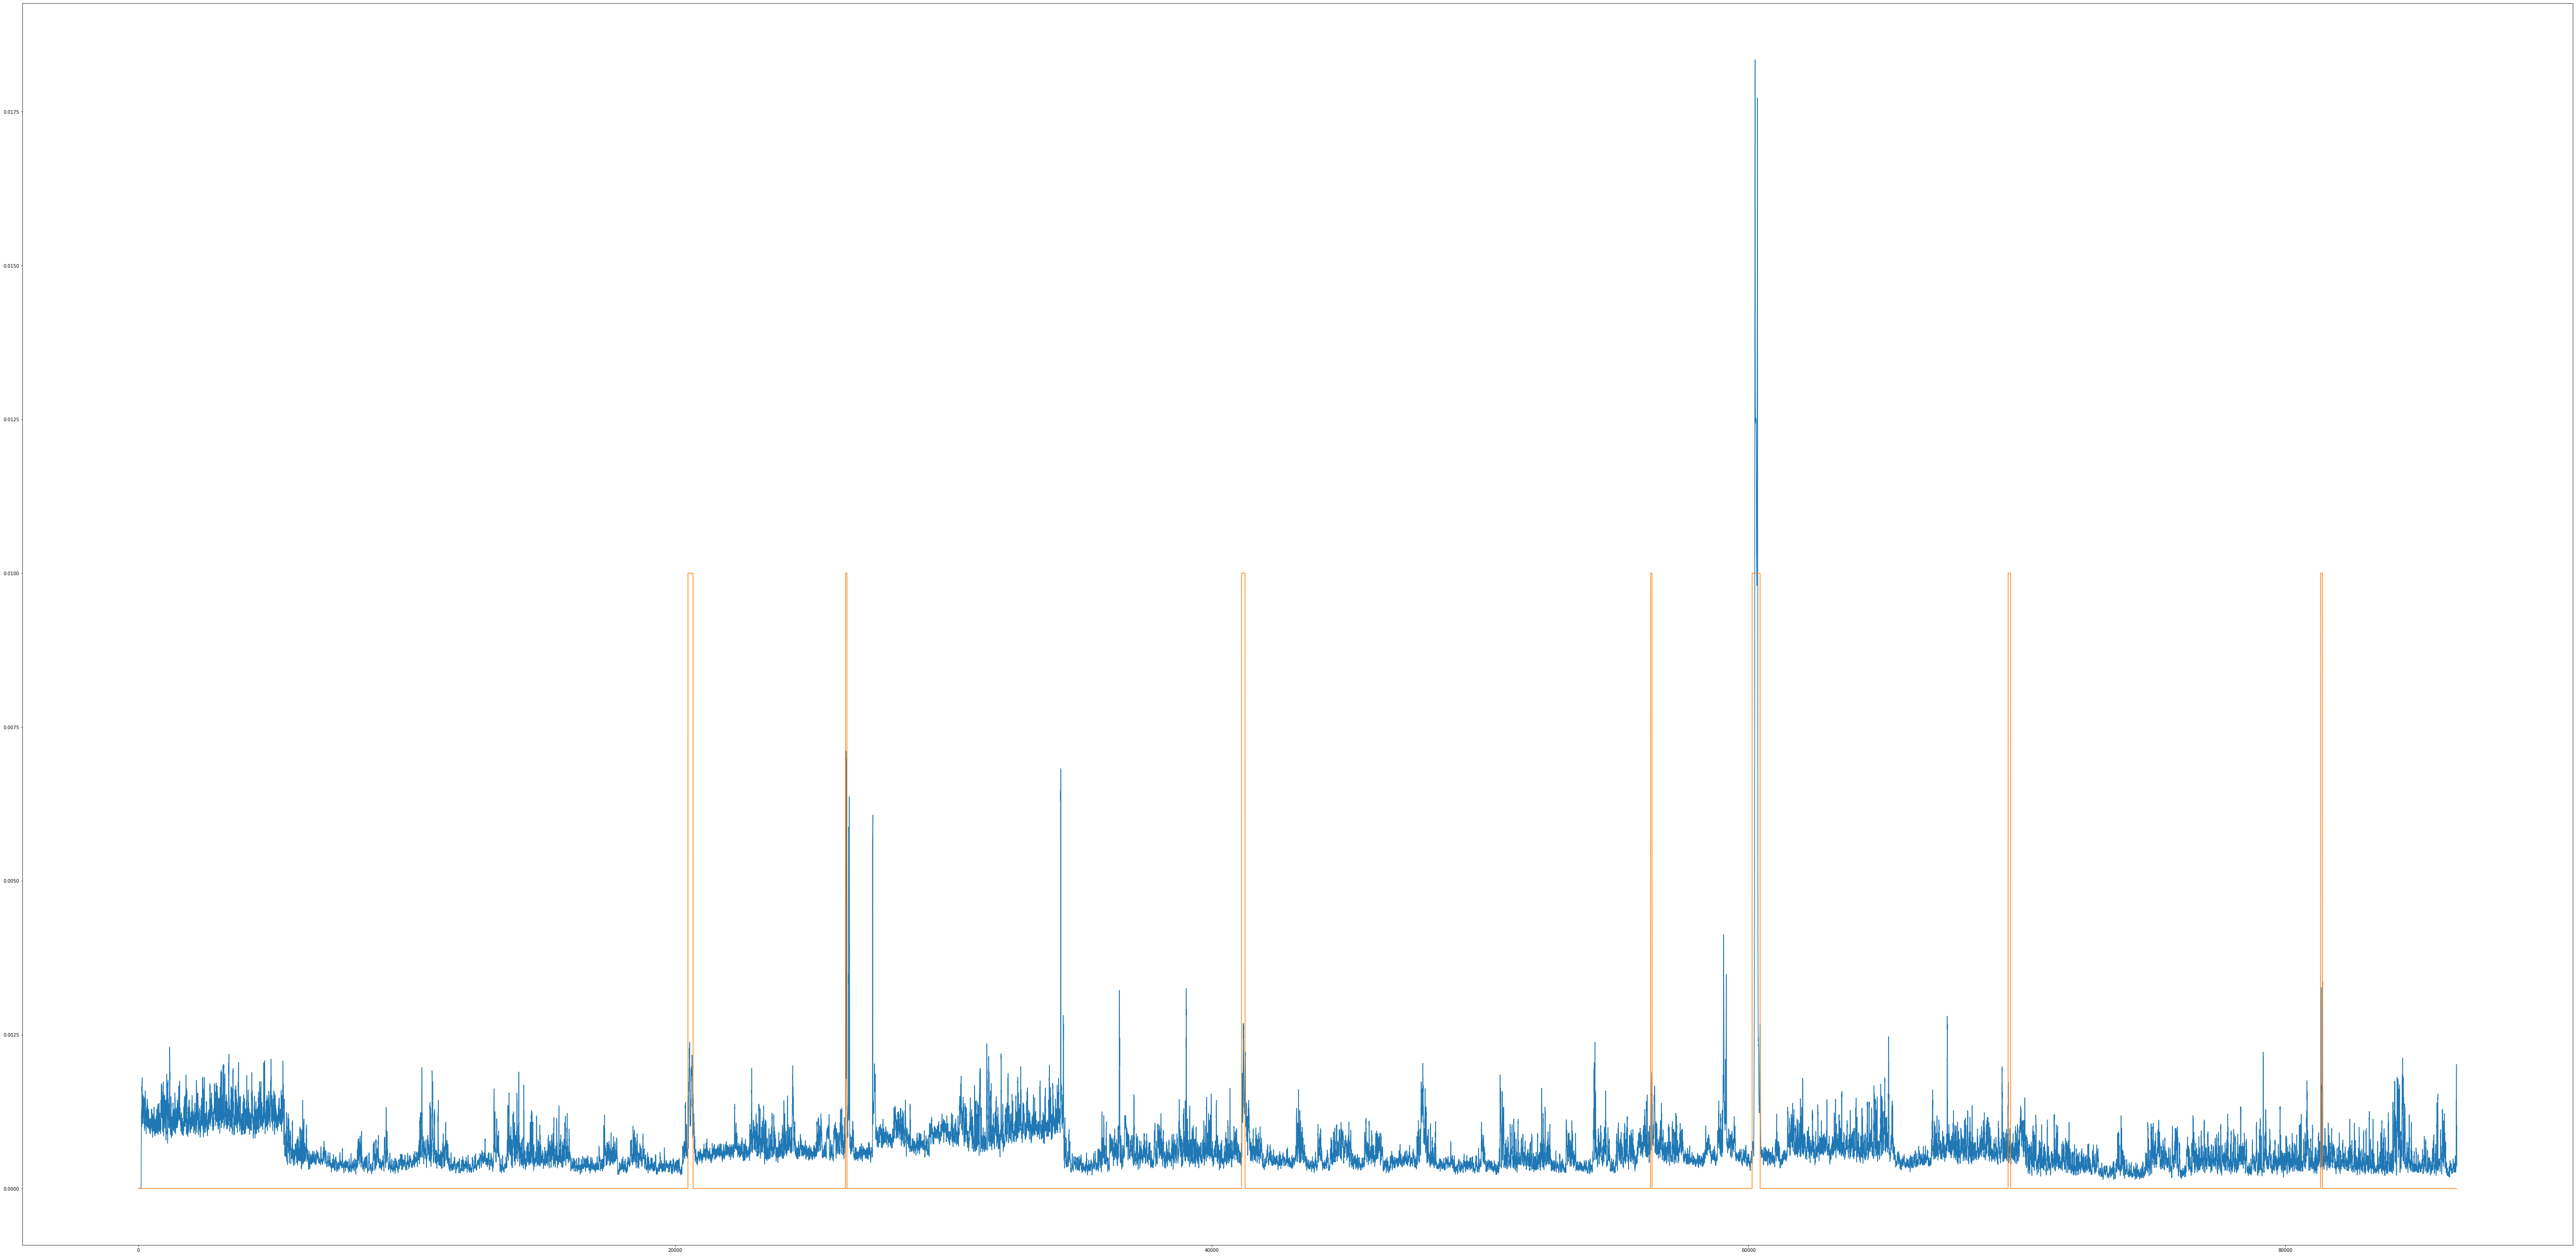

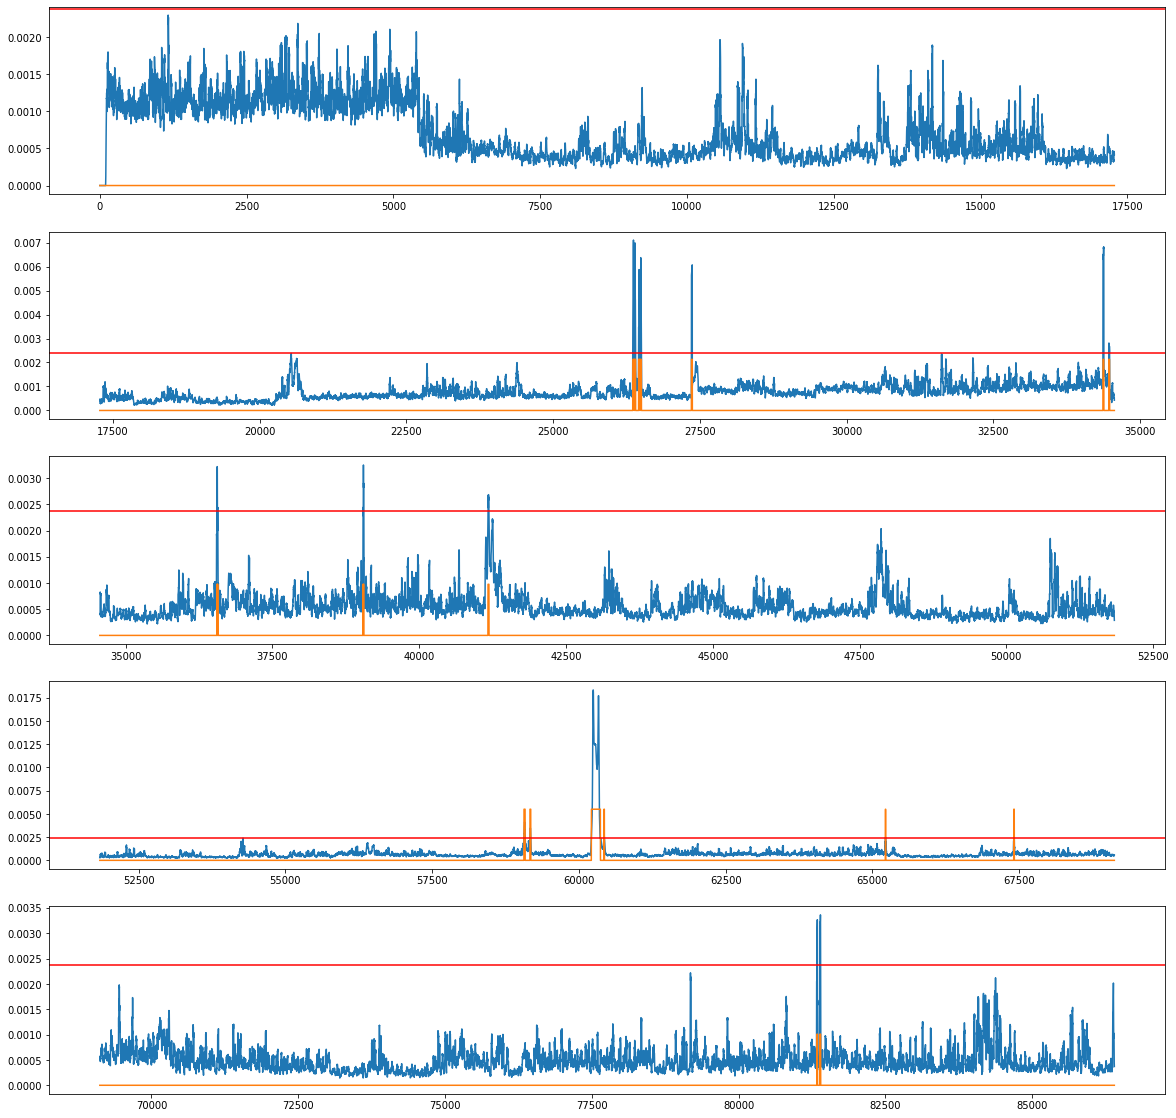

Finding Threshold:   0%|                                                              | 1/2000 [00:00<03:41,  9.03it/s]

parameter : 20


Finding Threshold: 100%|███████████████████████████████████████████████████████████| 2000/2000 [03:29<00:00,  9.53it/s]


F1: 0.303 (TaP: 0.280, TaR: 0.330)
# of detected anomalies: 4
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x00000261DFE65DF0>, <TaPR_pkg.DataManage.Range.Range object at 0x00000261DFE656A0>, <TaPR_pkg.DataManage.Range.Range object at 0x000002610B767940>, <TaPR_pkg.DataManage.Range.Range object at 0x00000261B79755E0>]
Threshold :  0.0023609


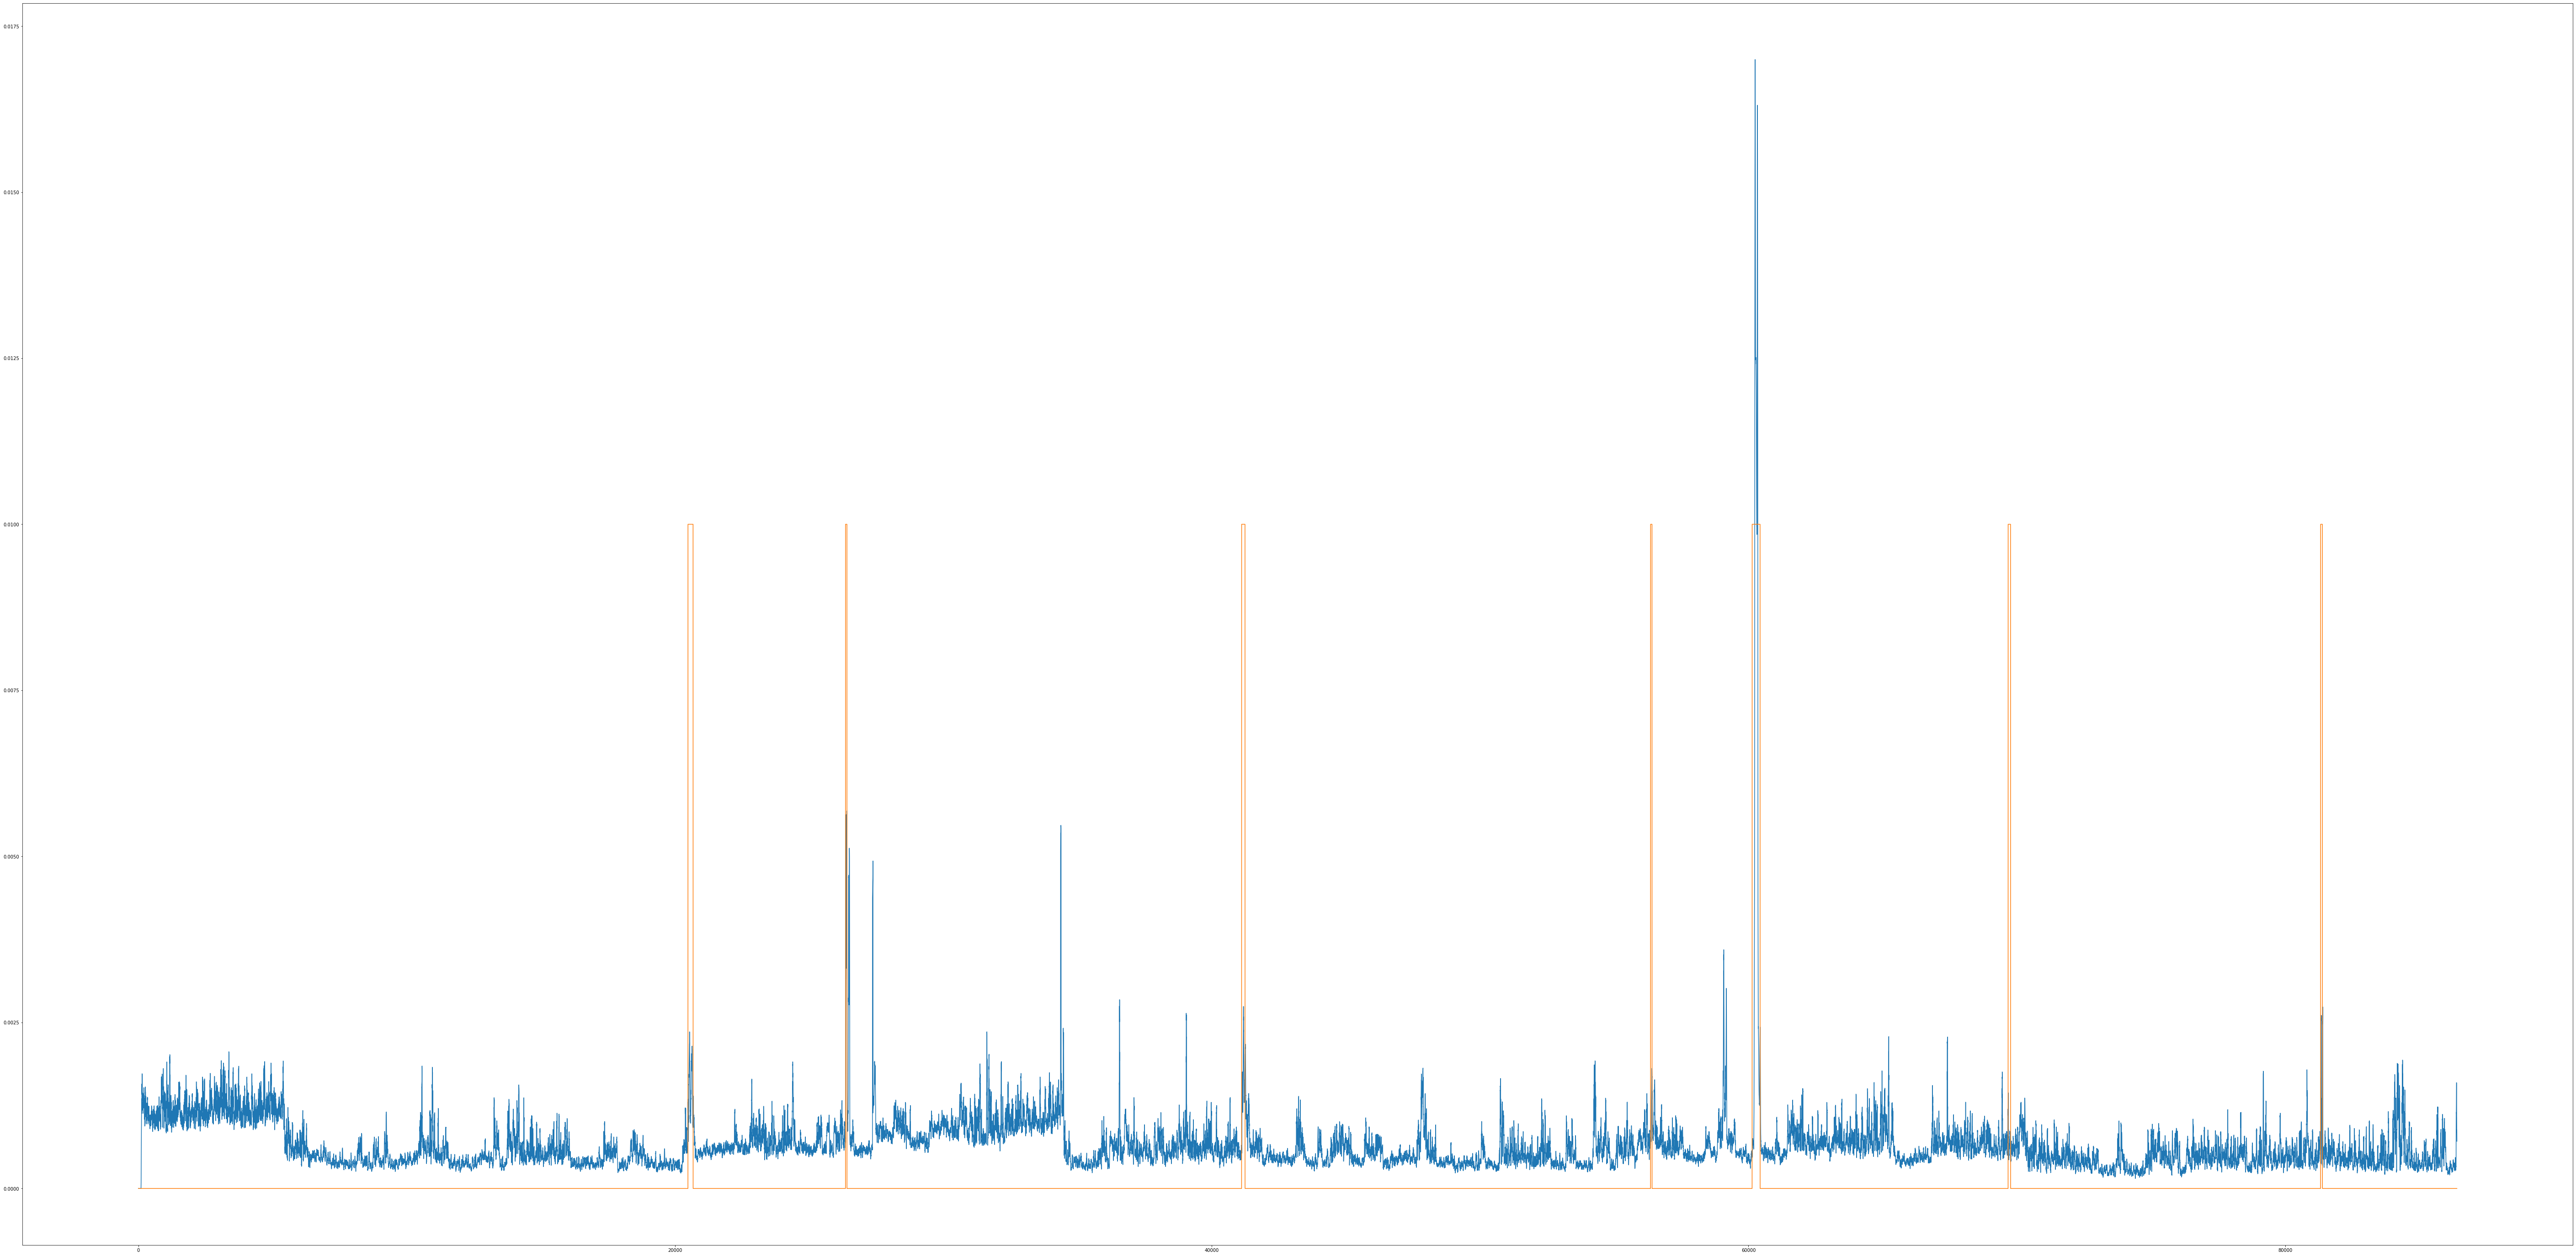

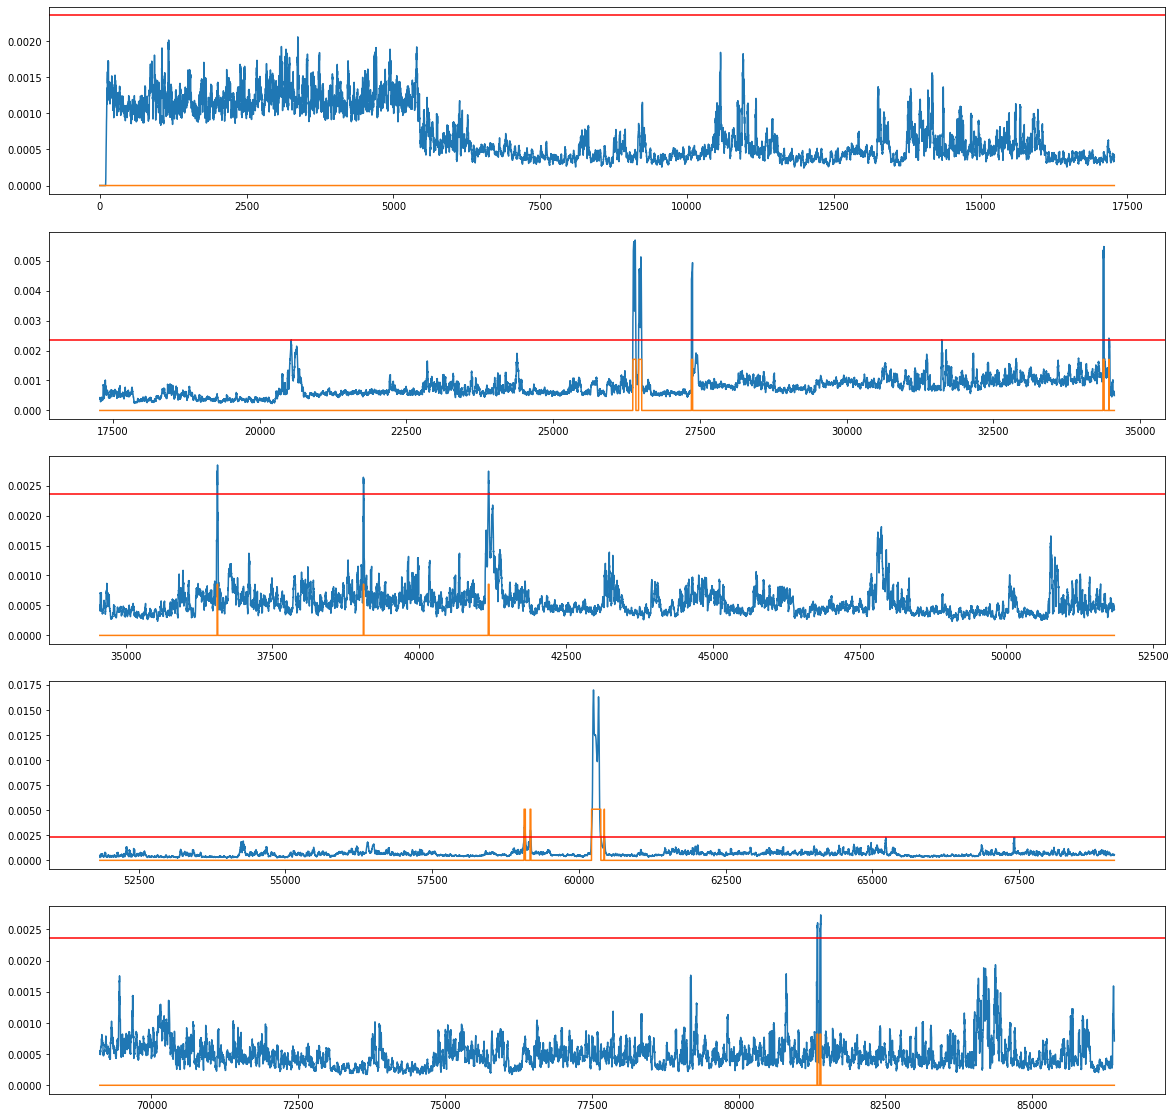

Finding Threshold:   0%|                                                              | 1/2000 [00:00<03:45,  8.87it/s]

parameter : 40


Finding Threshold: 100%|███████████████████████████████████████████████████████████| 2000/2000 [03:25<00:00,  9.74it/s]


F1: 0.301 (TaP: 0.283, TaR: 0.322)
# of detected anomalies: 4
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x000002610B7670D0>, <TaPR_pkg.DataManage.Range.Range object at 0x00000261B8C22250>, <TaPR_pkg.DataManage.Range.Range object at 0x00000261005CD670>, <TaPR_pkg.DataManage.Range.Range object at 0x00000261B980F520>]
Threshold :  0.0018758


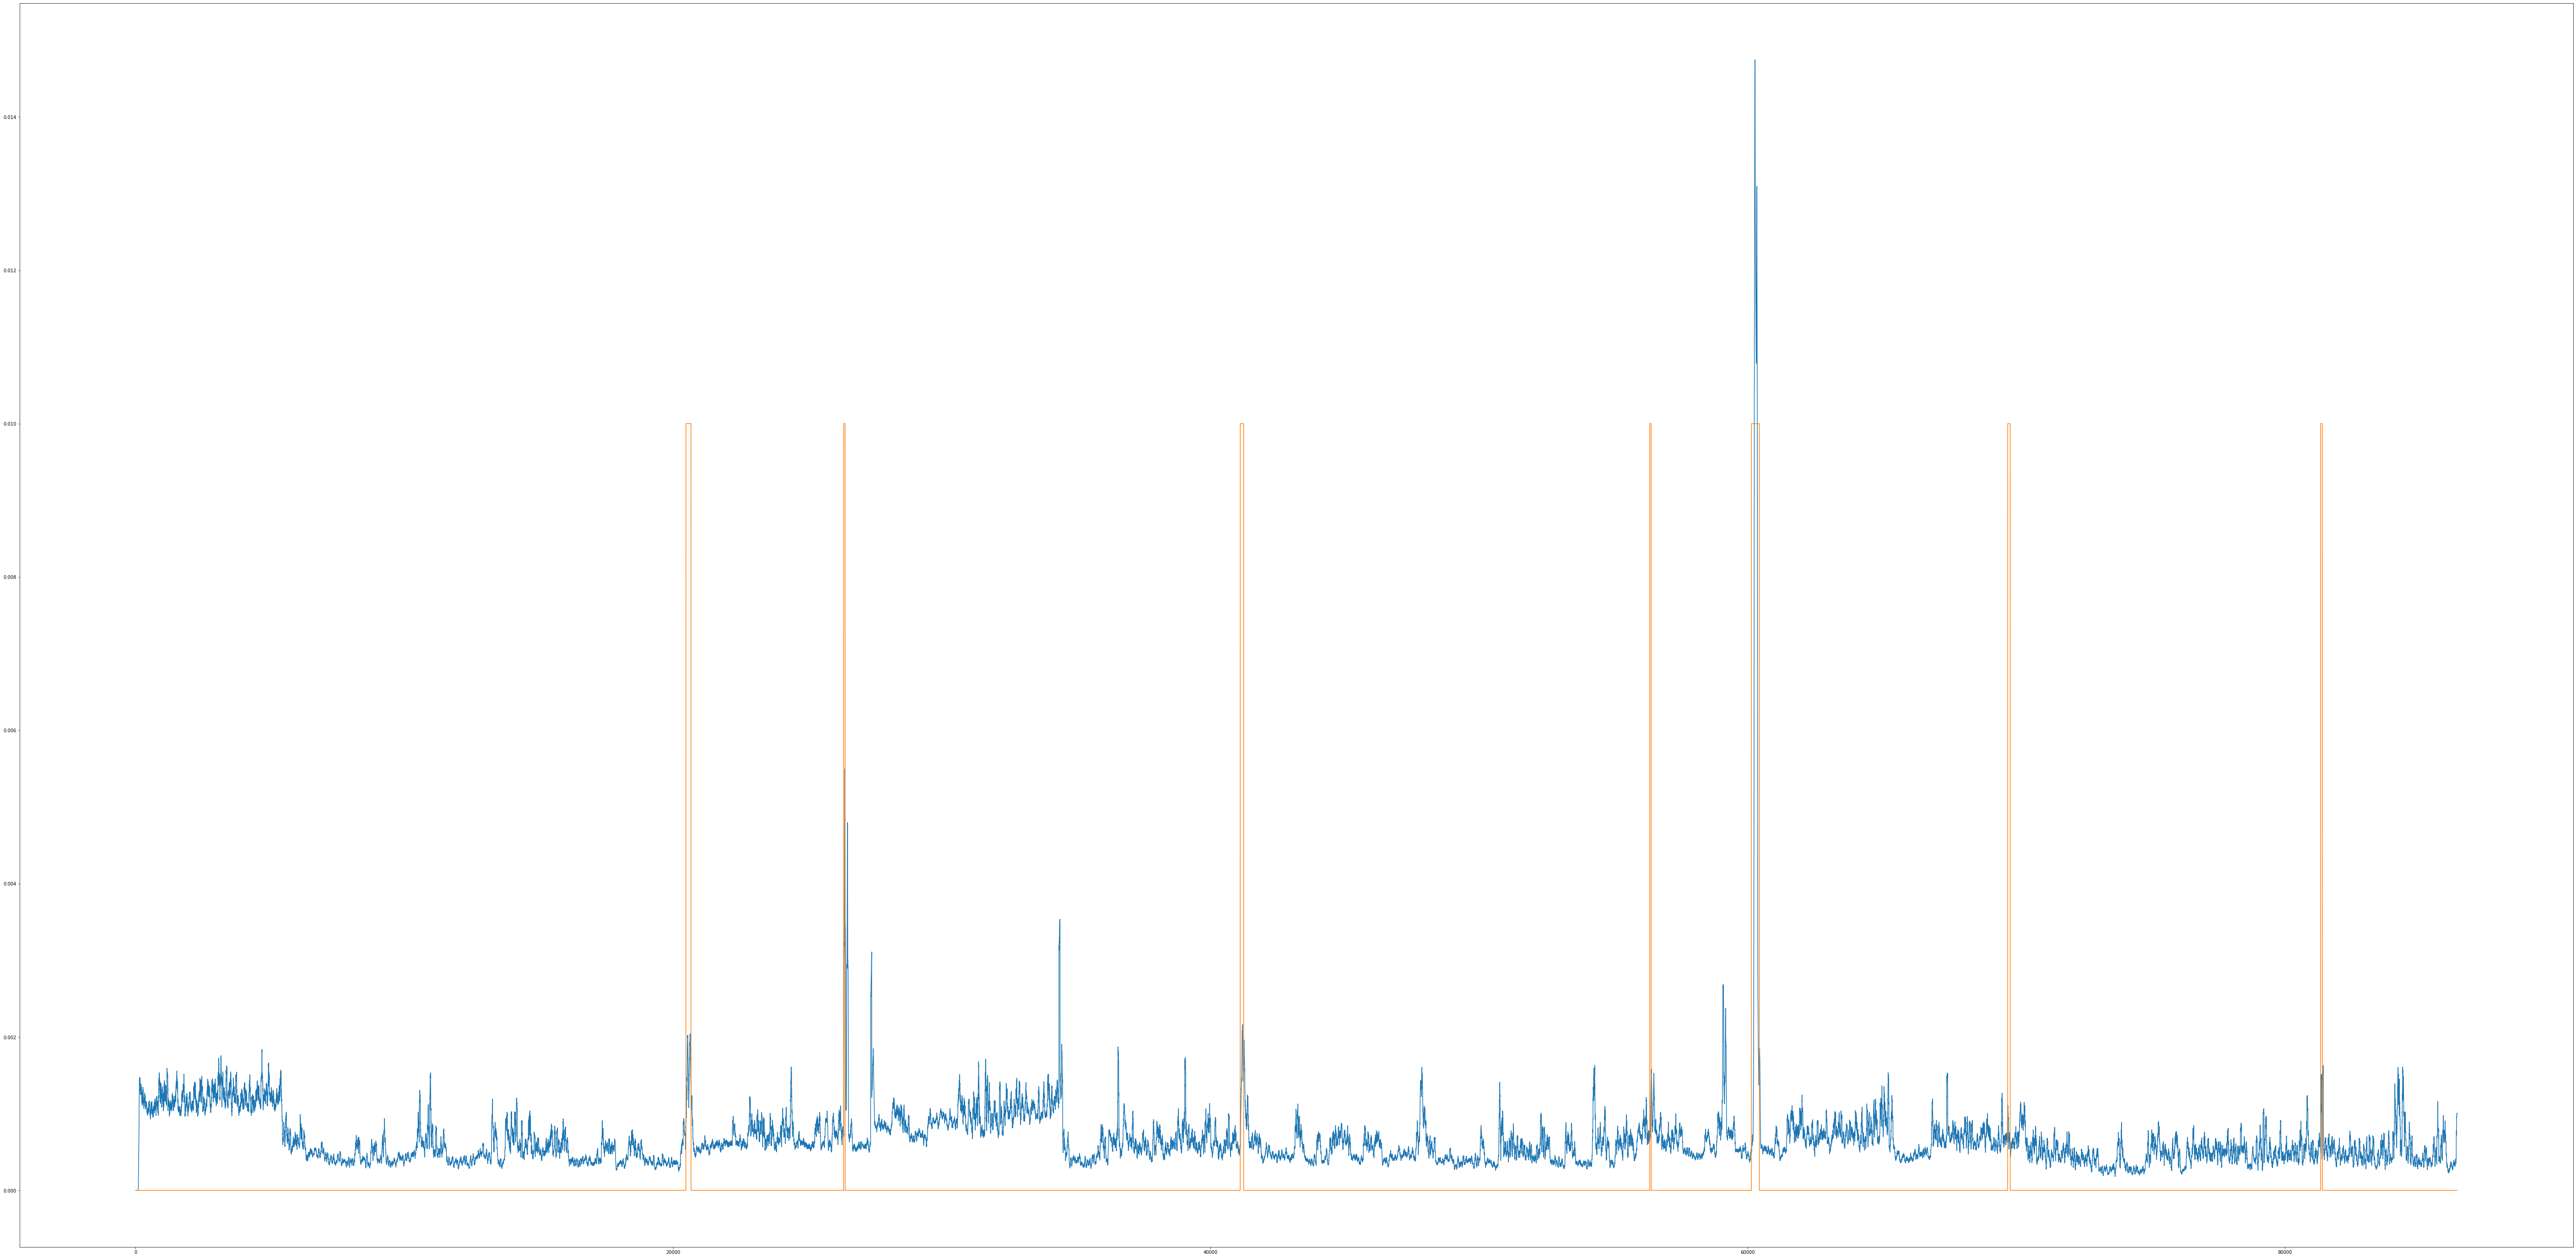

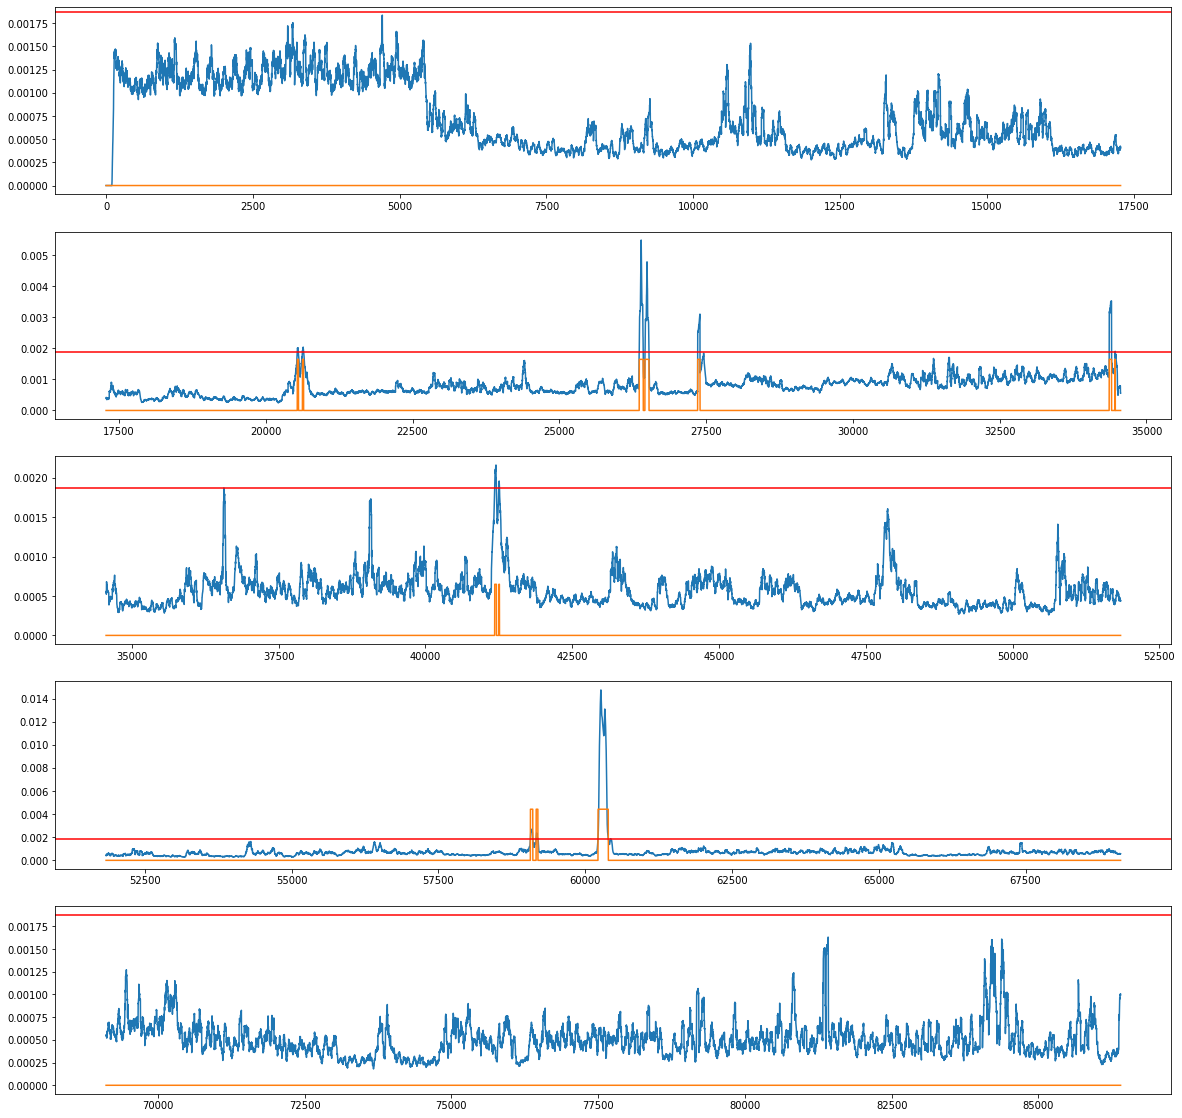

Finding Threshold:   0%|                                                              | 1/2000 [00:00<03:33,  9.37it/s]

parameter : 50


Finding Threshold: 100%|███████████████████████████████████████████████████████████| 2000/2000 [03:24<00:00,  9.79it/s]


F1: 0.307 (TaP: 0.296, TaR: 0.320)
# of detected anomalies: 4
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x00000261B97D0B80>, <TaPR_pkg.DataManage.Range.Range object at 0x00000261B97D0A60>, <TaPR_pkg.DataManage.Range.Range object at 0x00000261B97DC970>, <TaPR_pkg.DataManage.Range.Range object at 0x00000261B8CC4FD0>]
Threshold :  0.0018023000000000002


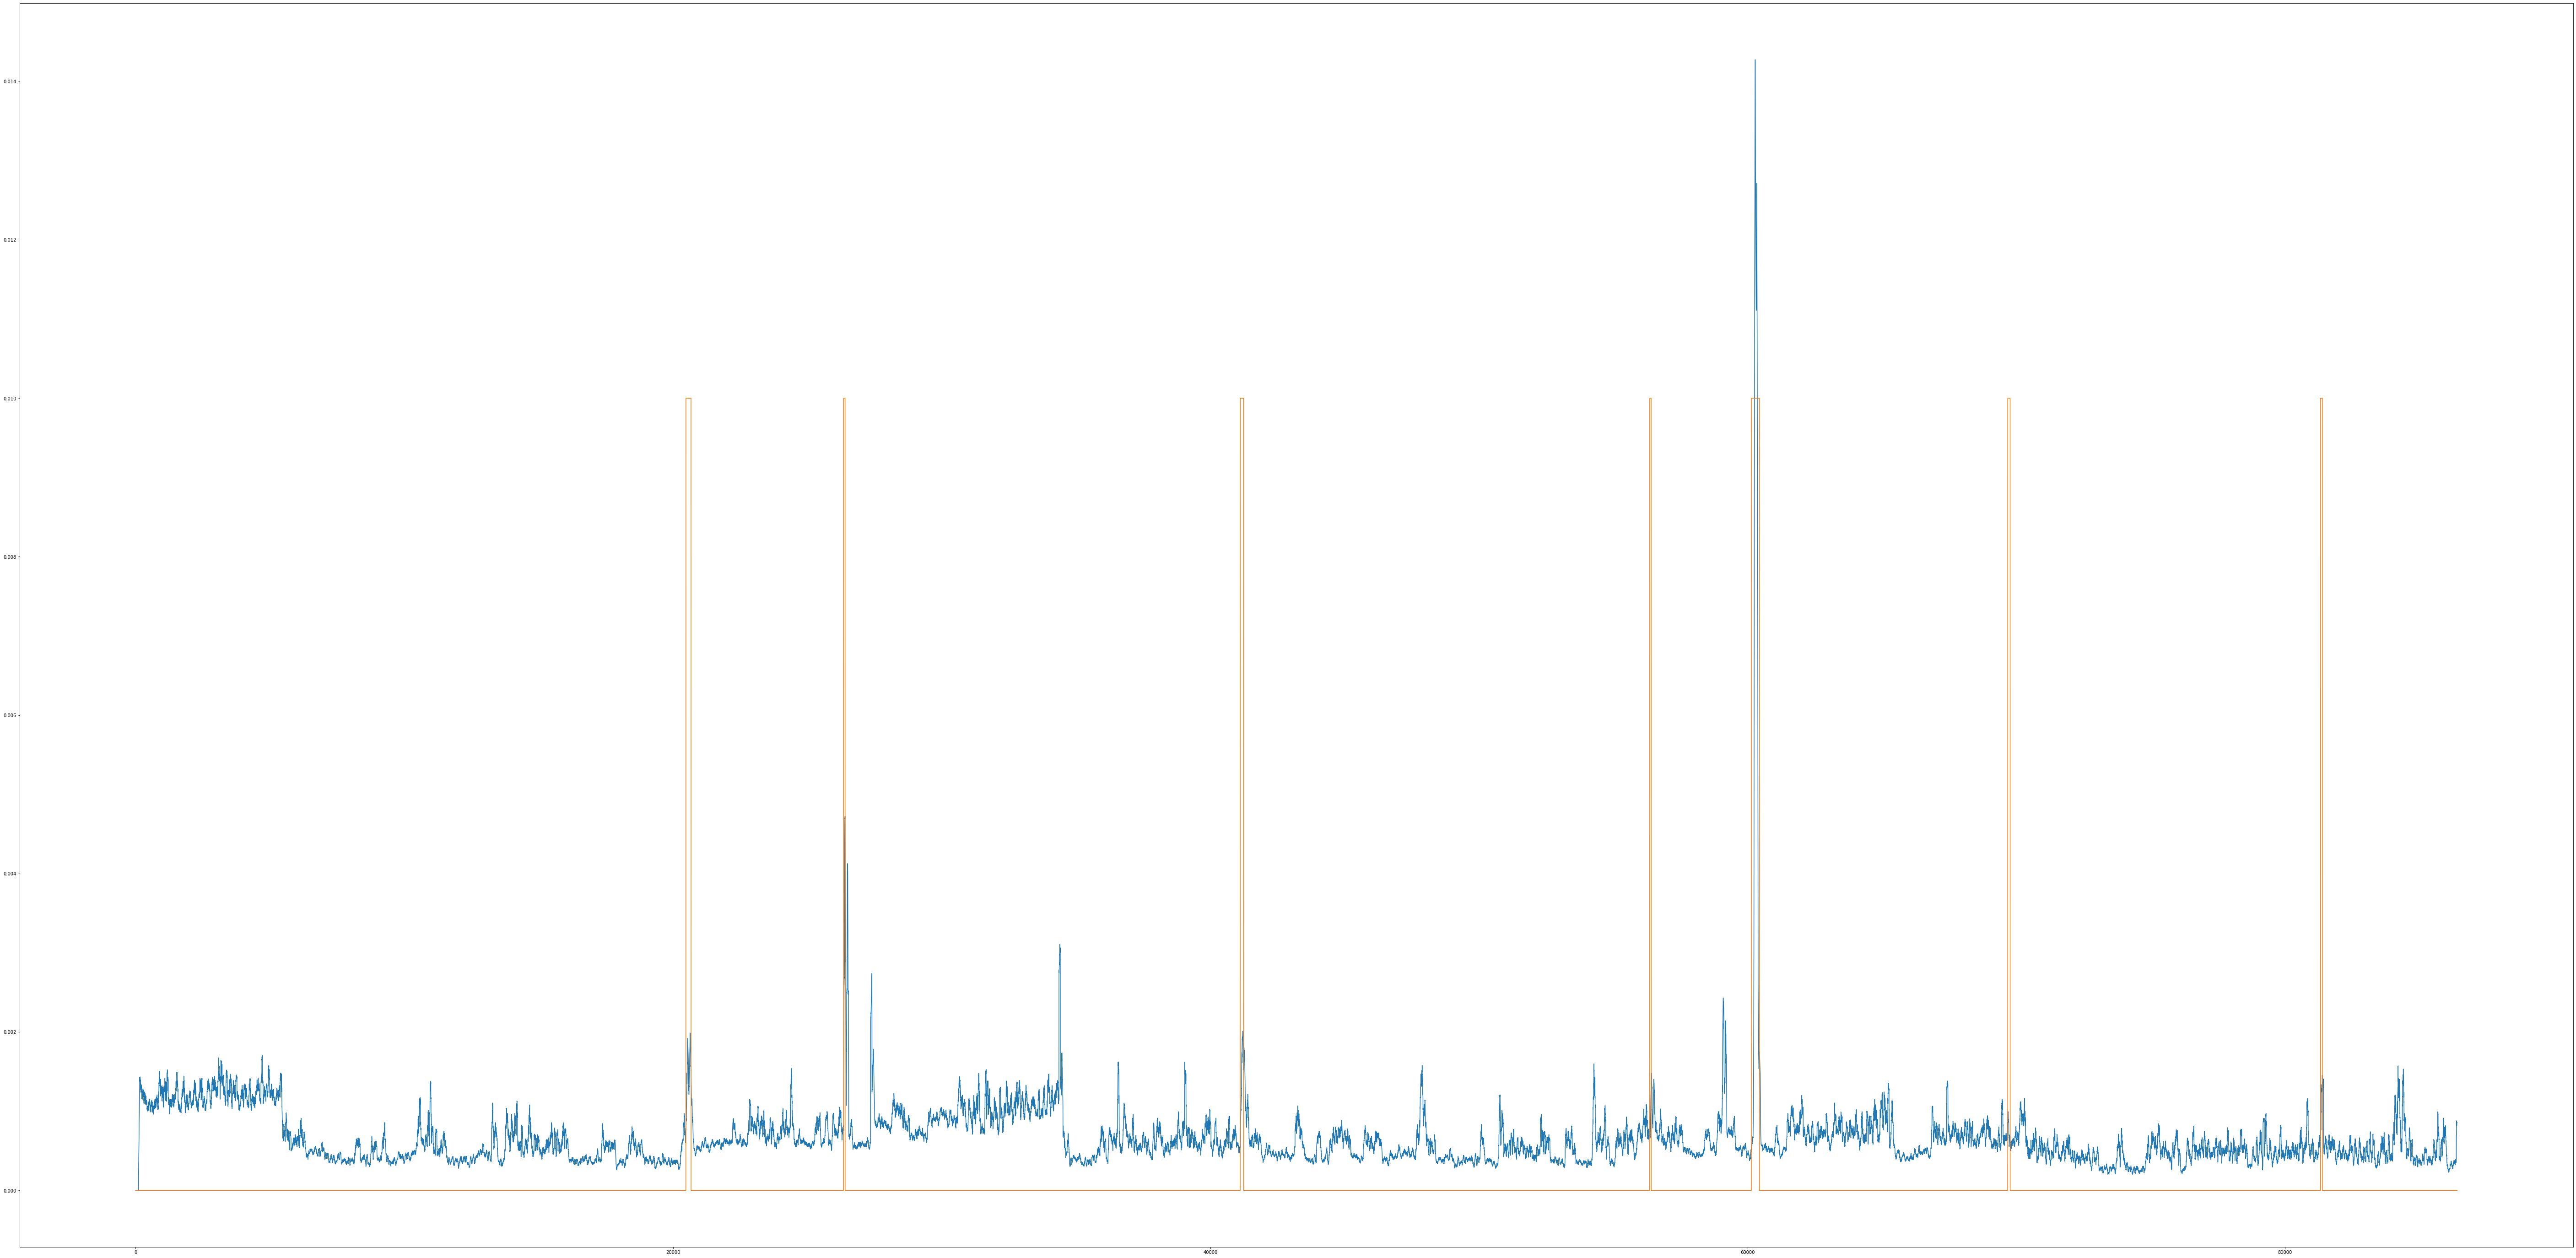

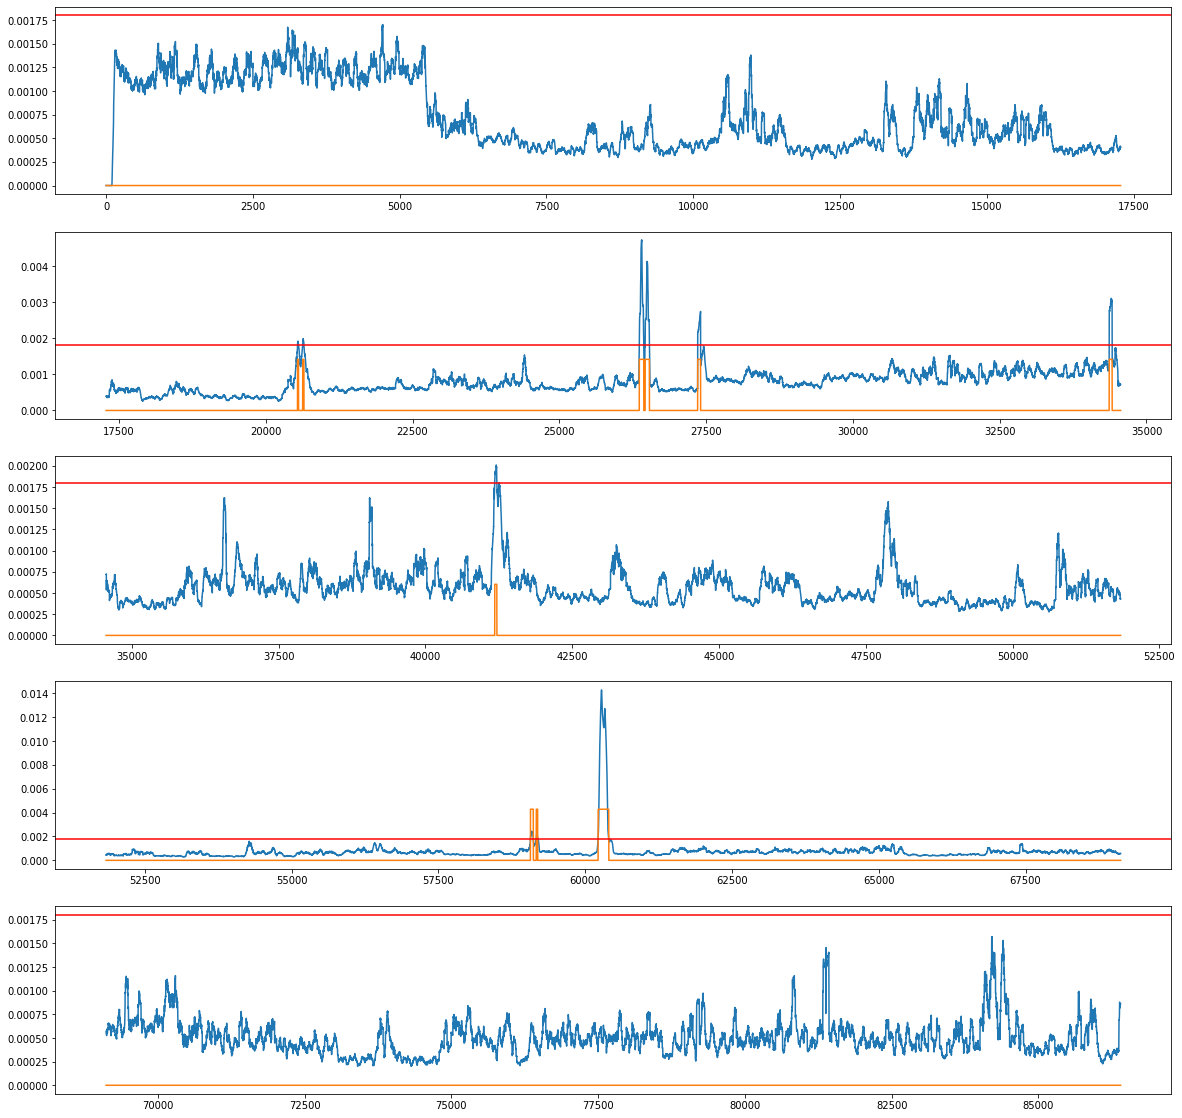

Finding Threshold:   0%|                                                              | 1/2000 [00:00<03:39,  9.12it/s]

parameter : 60


Finding Threshold: 100%|███████████████████████████████████████████████████████████| 2000/2000 [03:22<00:00,  9.87it/s]


F1: 0.330 (TaP: 0.292, TaR: 0.378)
# of detected anomalies: 4
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x00000261C2AD6700>, <TaPR_pkg.DataManage.Range.Range object at 0x00000261C2AD6820>, <TaPR_pkg.DataManage.Range.Range object at 0x00000261C2347A30>, <TaPR_pkg.DataManage.Range.Range object at 0x00000261C2B69C10>]
Threshold :  0.0016455


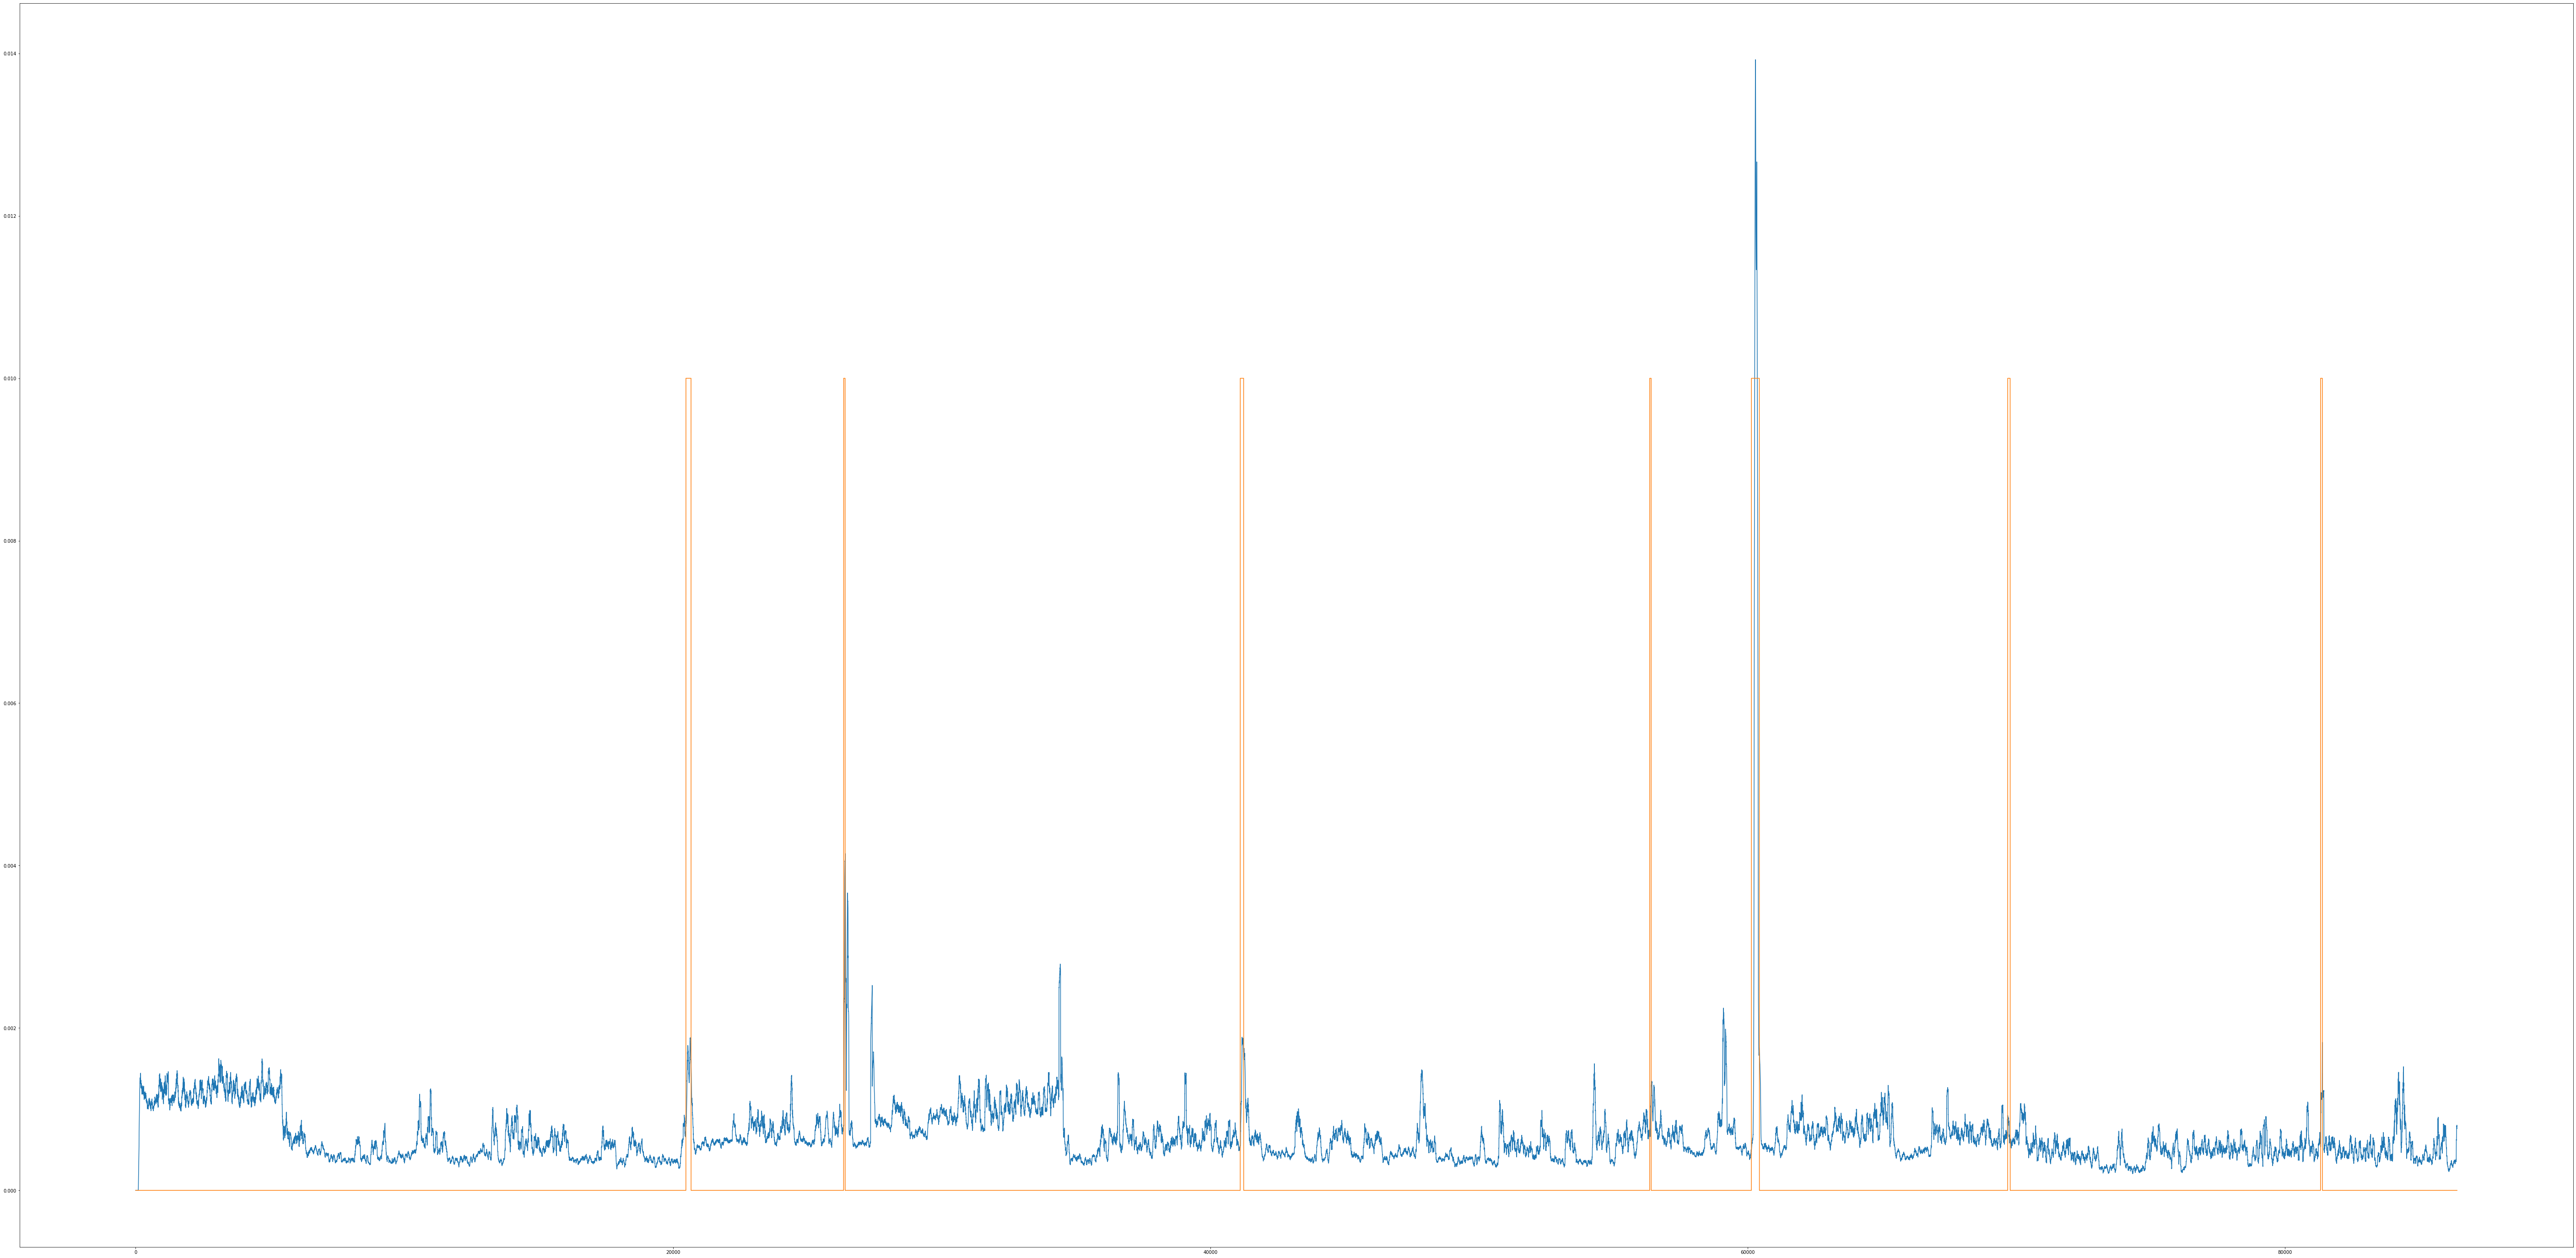

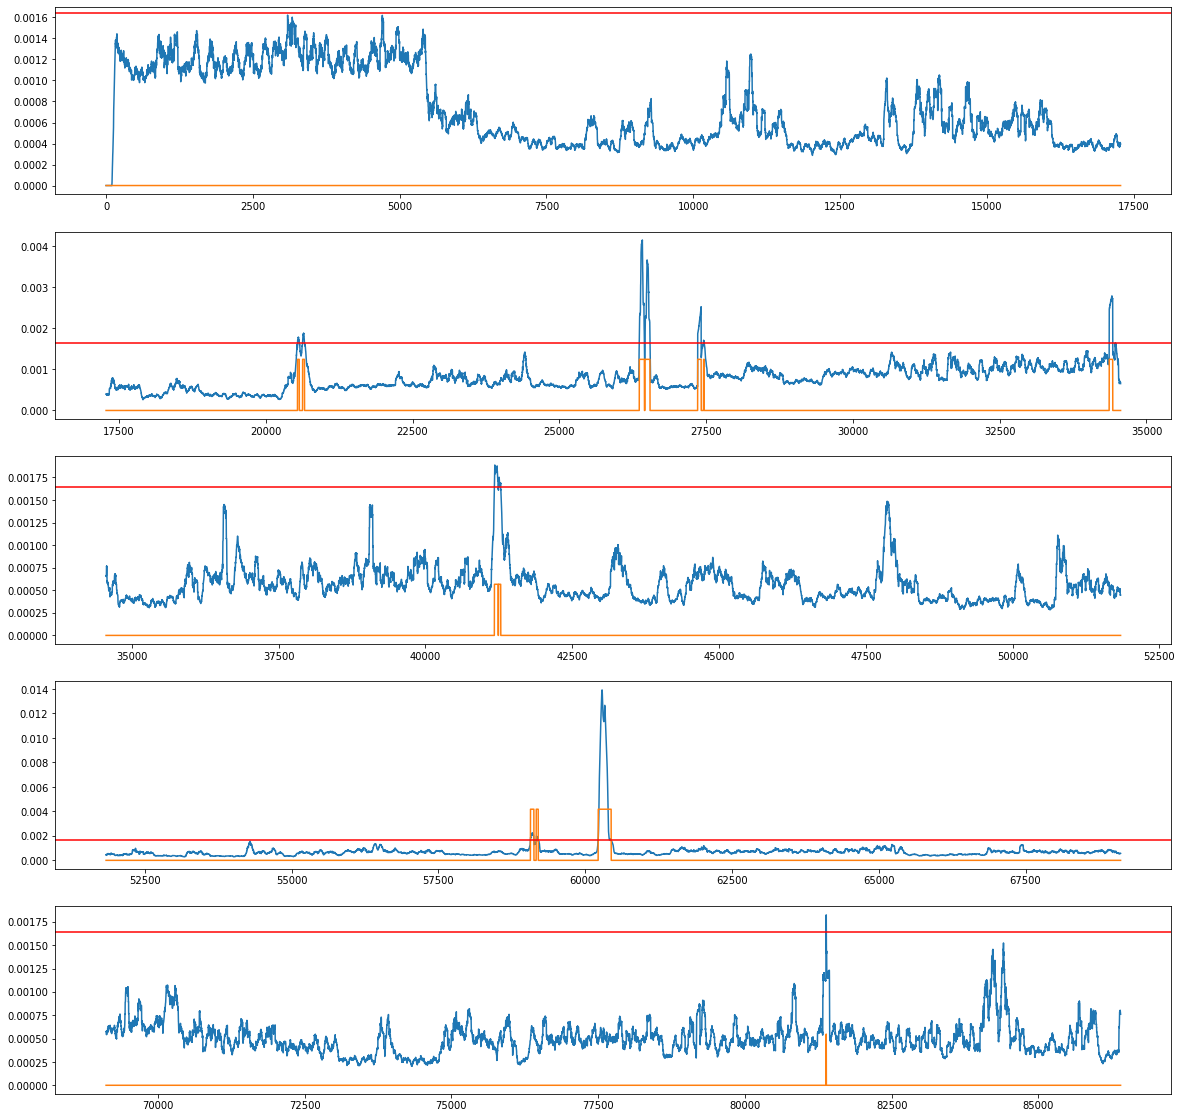

Finding Threshold:   0%|                                                              | 1/2000 [00:00<03:41,  9.03it/s]

parameter : 70


Finding Threshold: 100%|███████████████████████████████████████████████████████████| 2000/2000 [03:22<00:00,  9.87it/s]


F1: 0.278 (TaP: 0.279, TaR: 0.278)
# of detected anomalies: 3
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x00000261005CD670>, <TaPR_pkg.DataManage.Range.Range object at 0x00000261B6ECAC40>, <TaPR_pkg.DataManage.Range.Range object at 0x00000261B9D18040>]
Threshold :  0.0016504


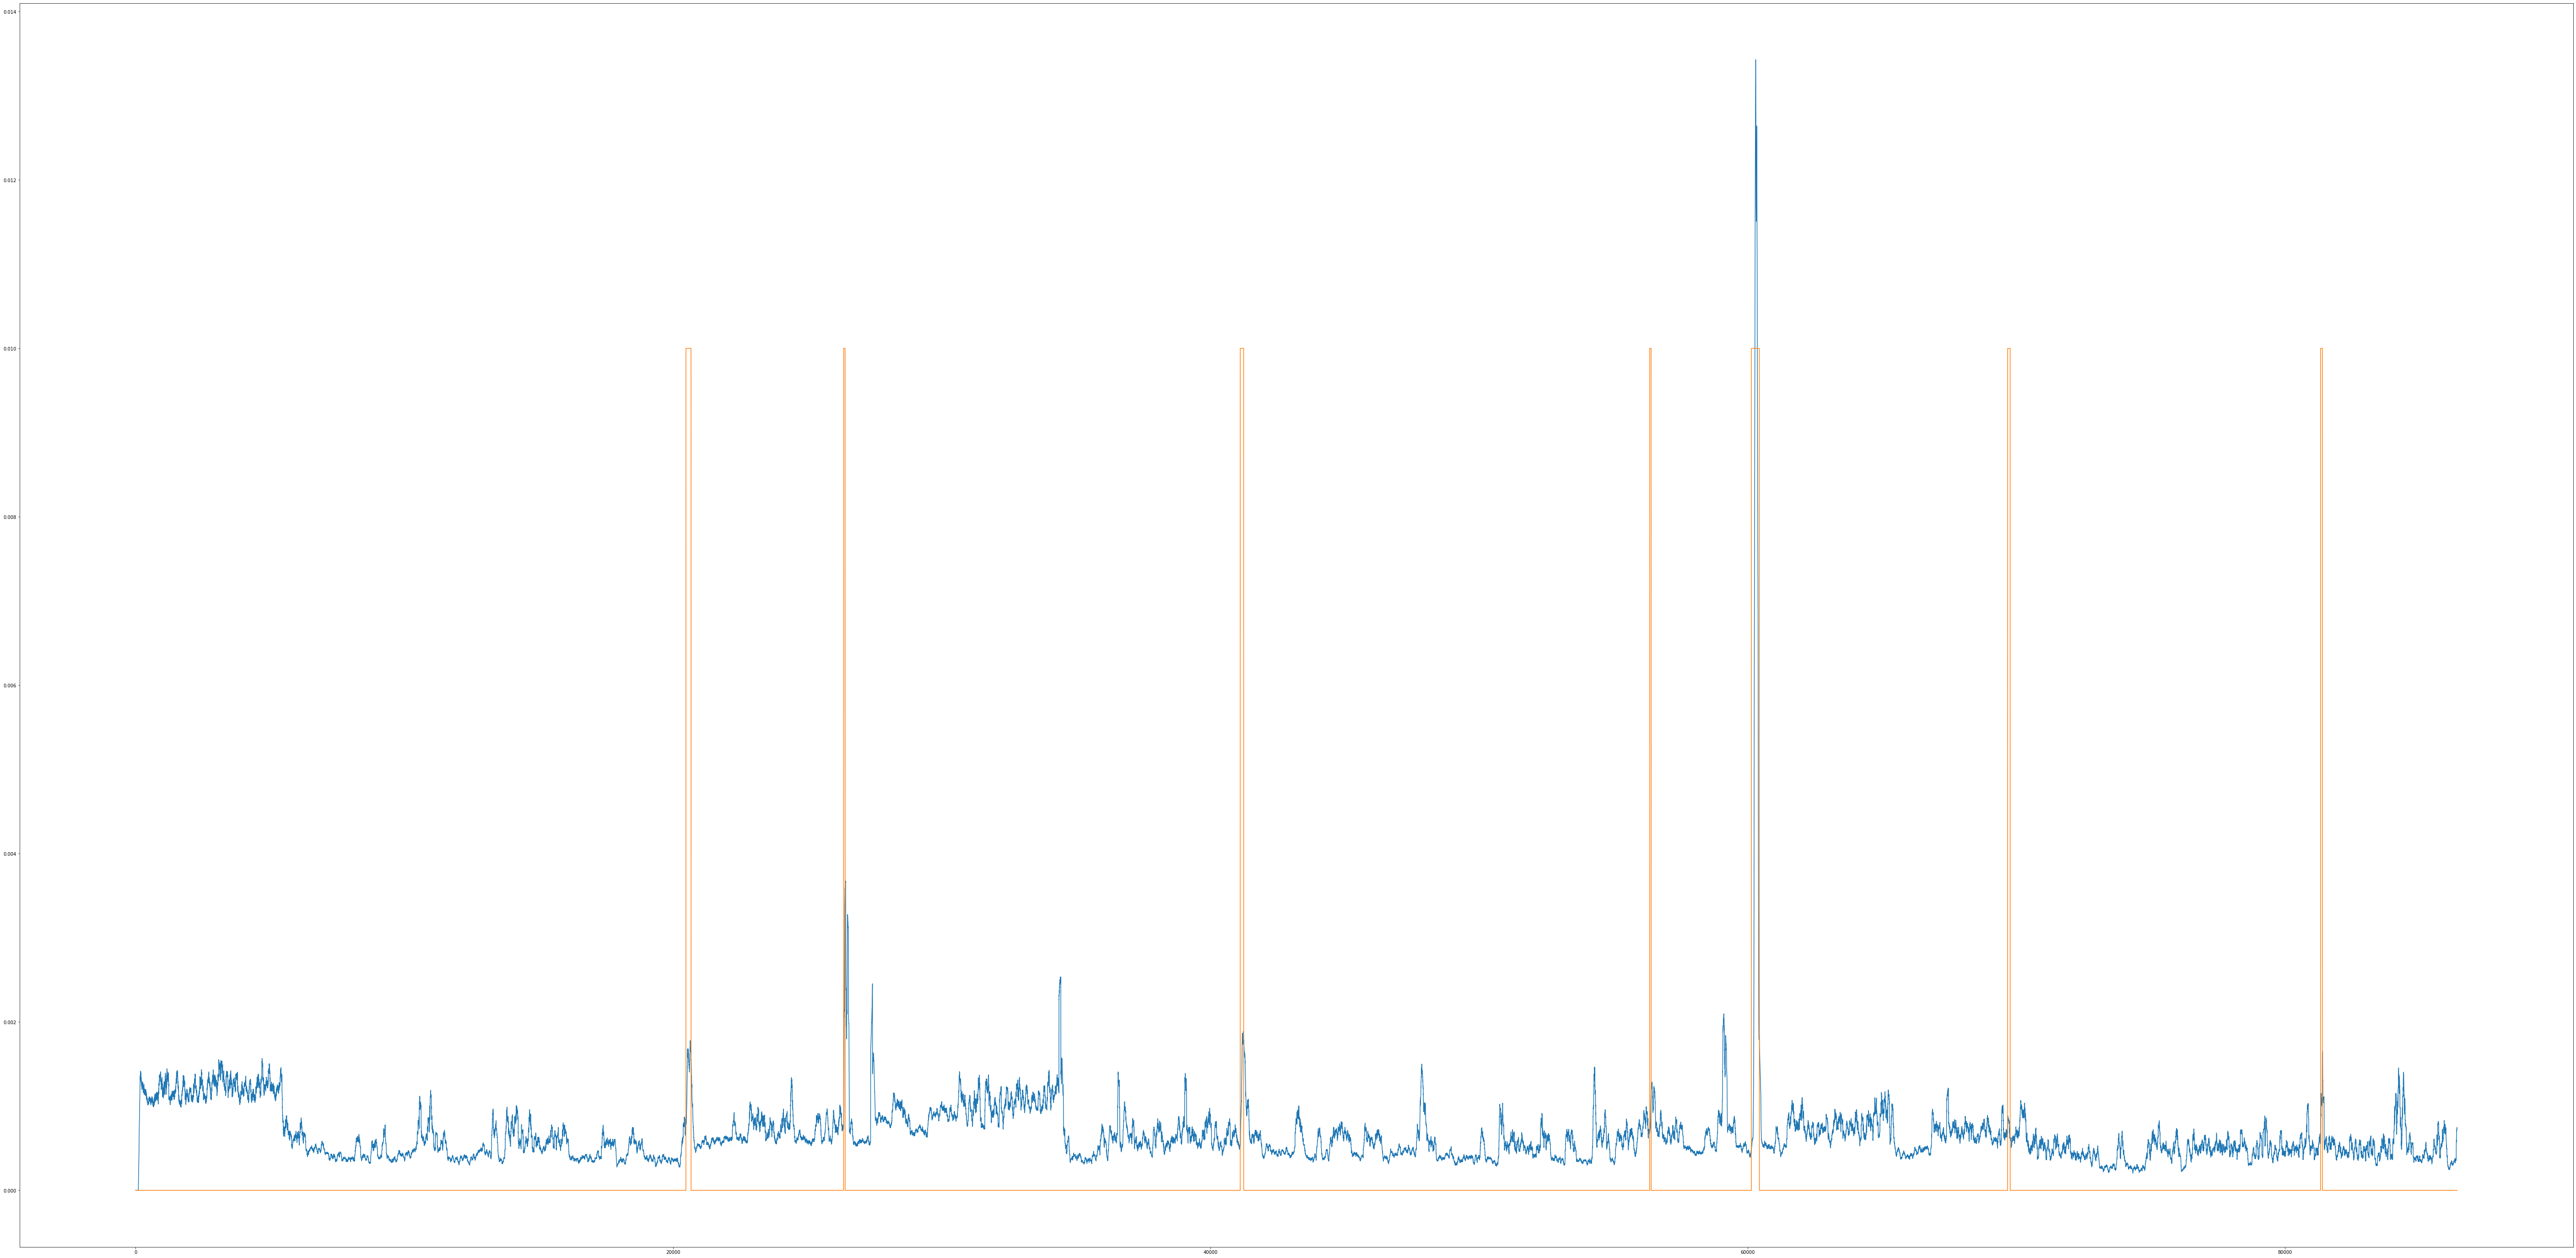

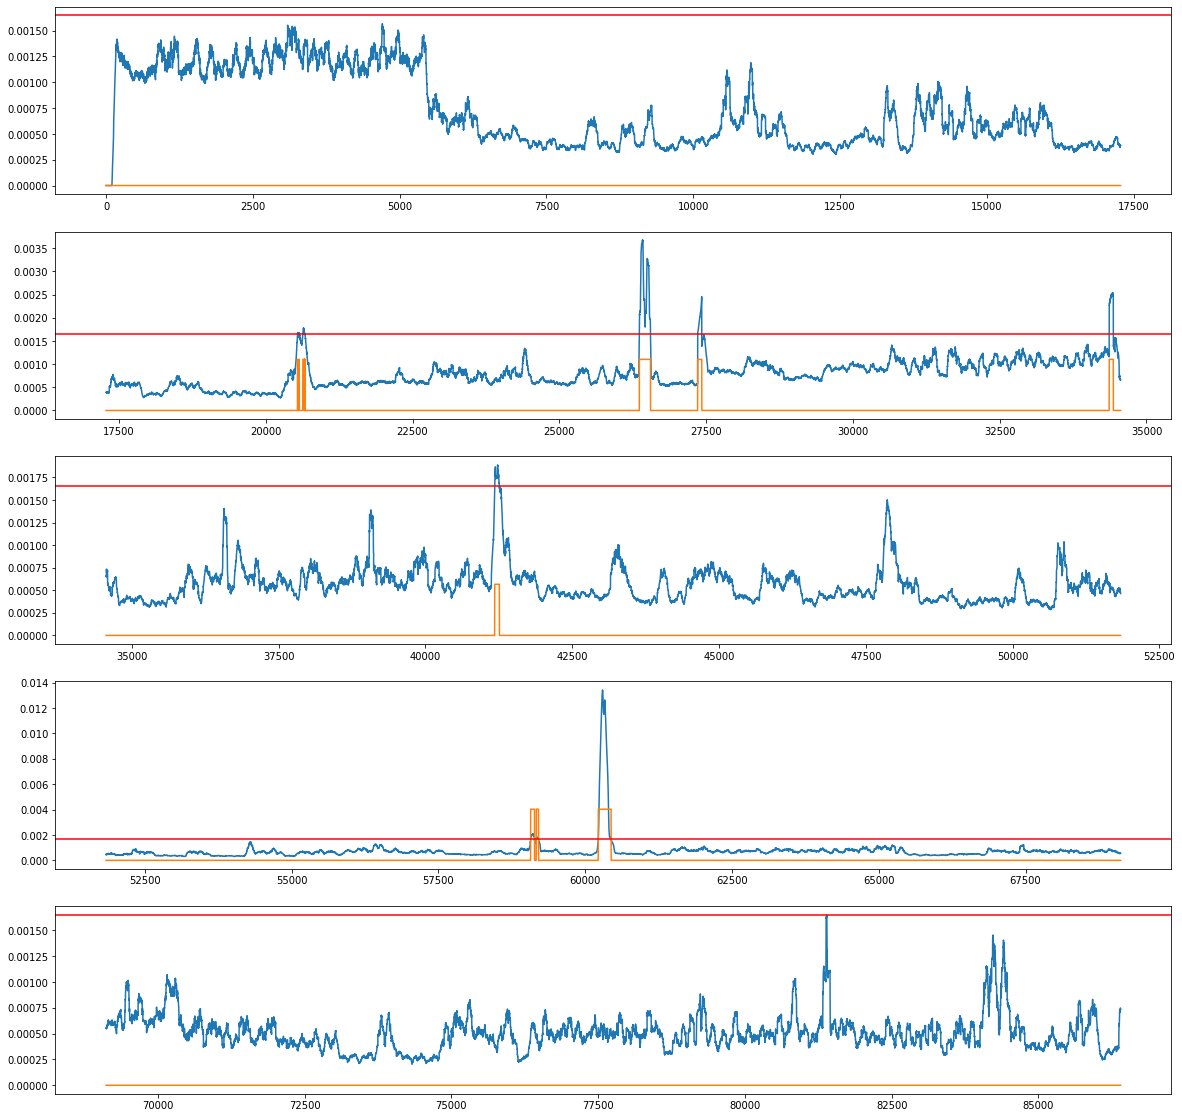

Finding Threshold:   0%|                                                              | 1/2000 [00:00<03:41,  9.03it/s]

parameter : 80


Finding Threshold: 100%|███████████████████████████████████████████████████████████| 2000/2000 [03:25<00:00,  9.74it/s]


F1: 0.273 (TaP: 0.248, TaR: 0.304)
# of detected anomalies: 3
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x00000261B8CC3F40>, <TaPR_pkg.DataManage.Range.Range object at 0x00000261B74299D0>, <TaPR_pkg.DataManage.Range.Range object at 0x00000261B7429B20>]
Threshold :  0.0015034


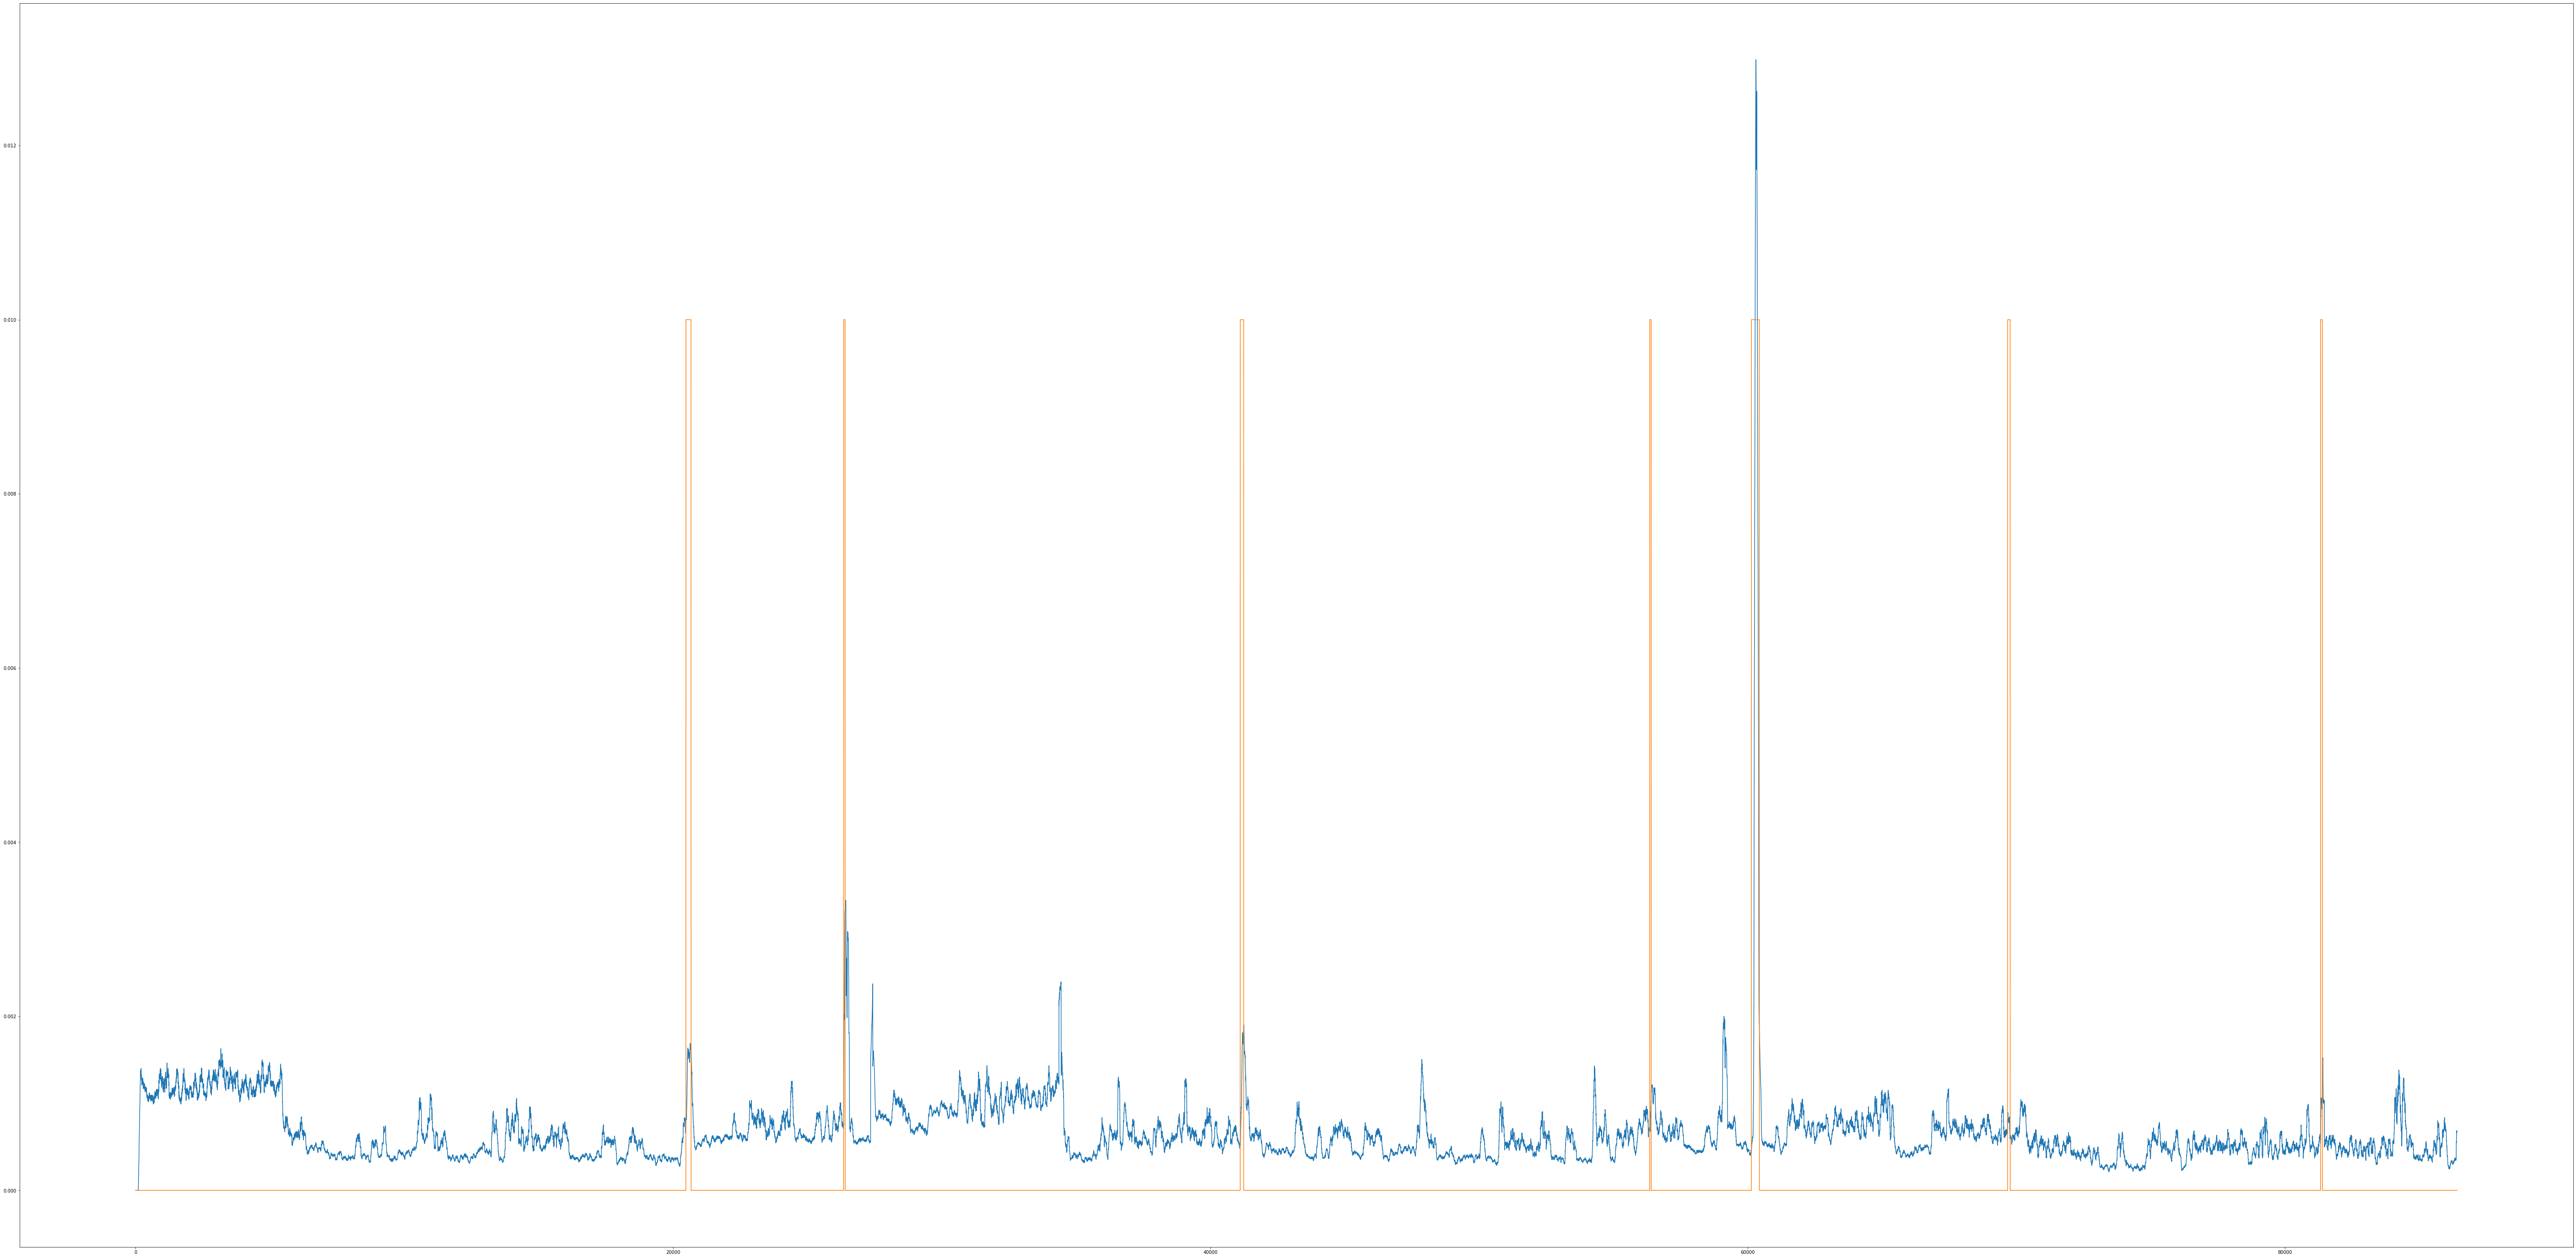

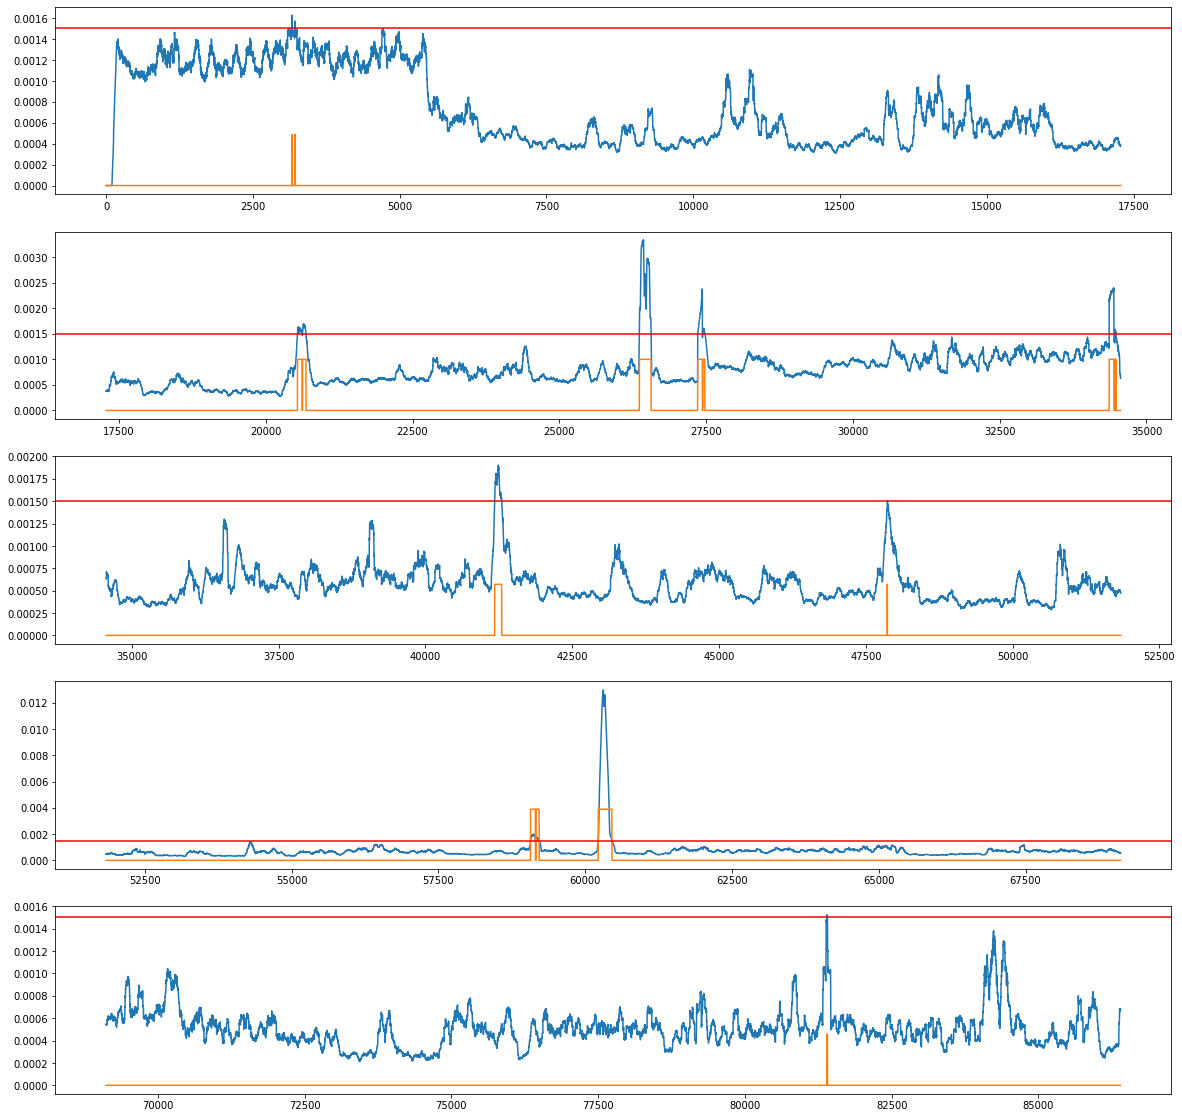

Finding Threshold:   0%|                                                              | 1/2000 [00:00<03:43,  8.95it/s]

parameter : 100


Finding Threshold: 100%|███████████████████████████████████████████████████████████| 2000/2000 [03:22<00:00,  9.86it/s]


F1: 0.225 (TaP: 0.229, TaR: 0.220)
# of detected anomalies: 2
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x00000261C2F70340>, <TaPR_pkg.DataManage.Range.Range object at 0x00000261C2F7AC40>]
Threshold :  0.0015181


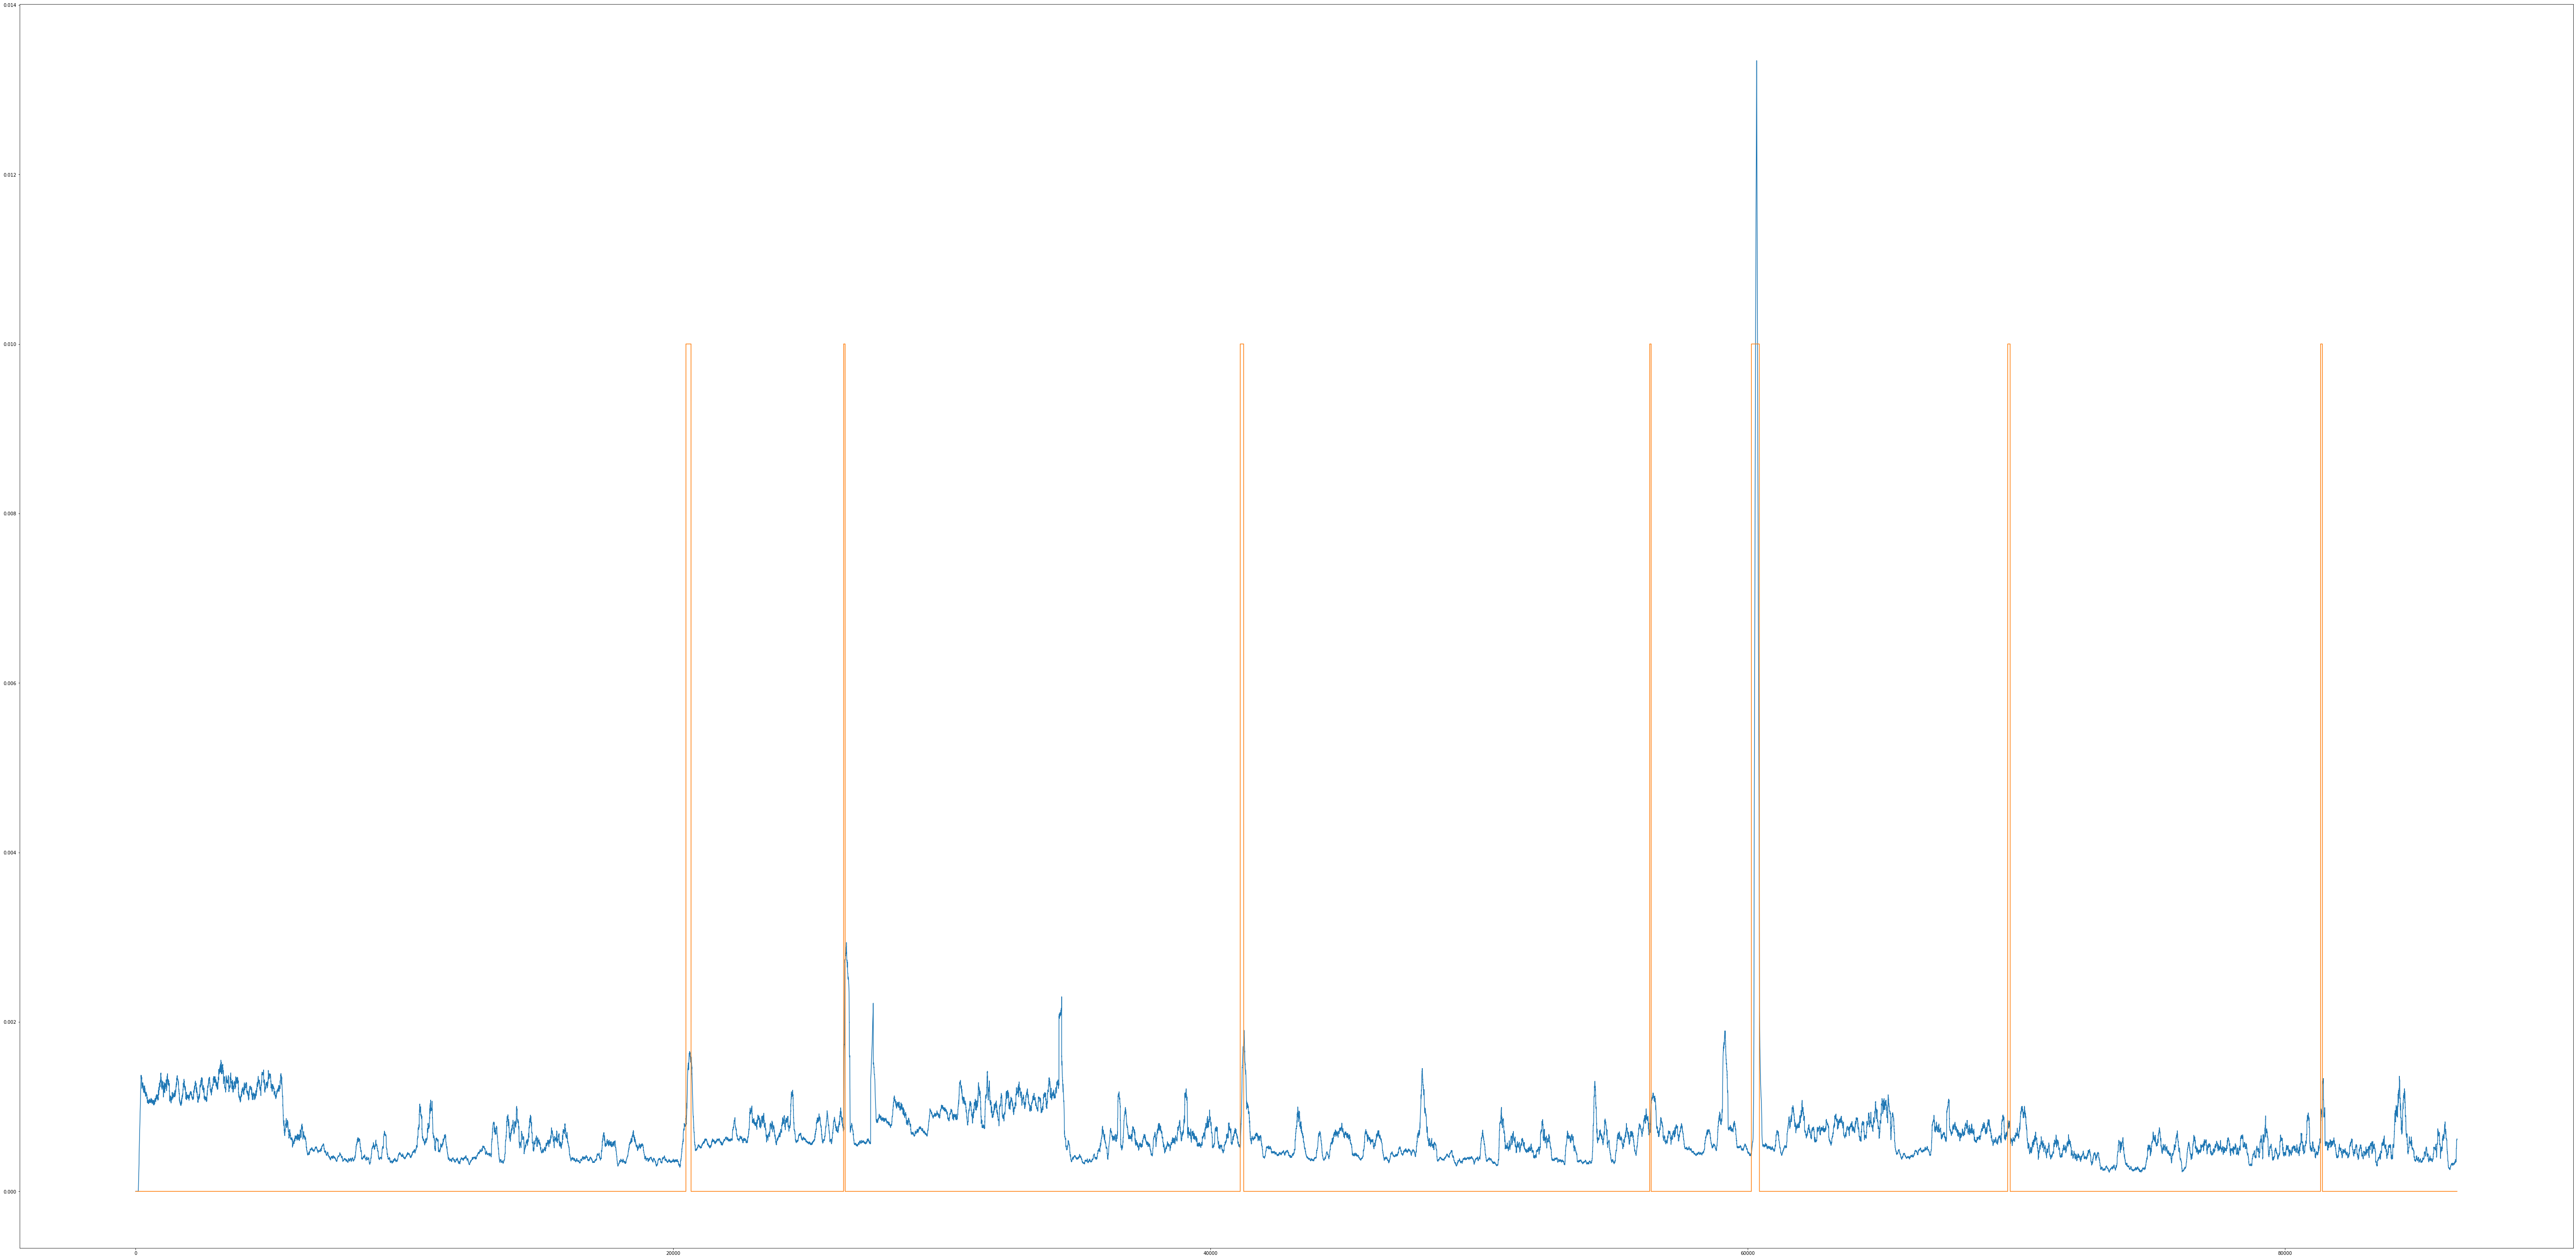

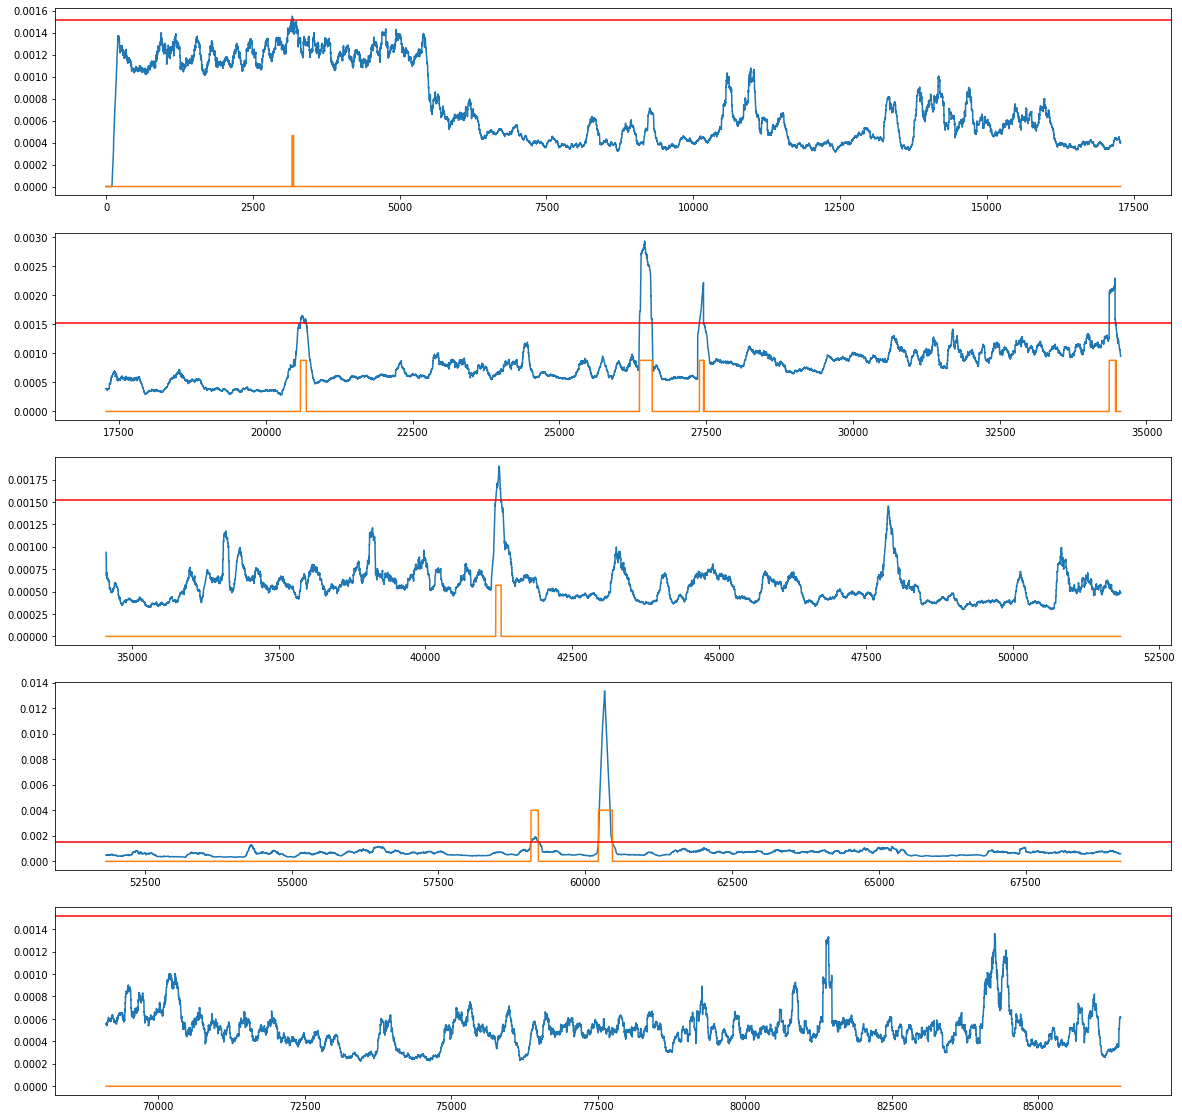

In [10]:
parameters = [5, 10, 15, 20, 40, 50, 60, 70, 80, 100]
filters = [filter0_factory(ws) for ws in parameters]
noise_filtering_test(parameters, filters)

In [ ]:
parameters = [2, 4, 8, 16, 32, 64, 128]
filters = [filter1_factory(n) for n in parameters]
noise_filtering_test(parameters, filters)

In [ ]:
parameters = [5, 10, 15, 20, 40, 50, 60, 70, 80, 100]
filters = [filter2_factory(ws) for ws in parameters]
noise_filtering_test(parameters, filters)

In [ ]:
parameters = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3]
filters = [filter3_factory(f) for f in parameters]
noise_filtering_test(parameters, filters)

TEST filtering
-----------